In [50]:
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as stats

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import random

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import operator


%matplotlib inline

plt.style.use('ggplot')

In [51]:
posts = pd.read_csv('data/posts.csv')

In [52]:
posts = posts.sort(['post_data', 'post_id'])

In [53]:
posts.head()

,post_id,post_data,post_name,post_tagline,post_comments,post_votes,post_url,user_id,user_name,user_nickname
14547,3,2013-11-24T09:48:46.357-08:00,Ferro,Keyboard interface to Google Chrome,1,4,http://www.producthunt.com/r/07638f3e05/3?app_...,2,Ryan Hoover,rrhoover
14548,6,2013-11-24T22:23:07.126-08:00,Michron,Timelapse for everyone,1,1,http://www.producthunt.com/r/ca2493c561/6?app_...,1,Nathan Bashaw,nbashaw
14546,7,2013-11-26T15:12:37.000-08:00,Product Hunt,Discover and geek out about cool new products,2,49,http://www.producthunt.com/r/470d17ca49/7?app_...,1,Nathan Bashaw,nbashaw
14529,9,2013-11-27T10:23:46.163-08:00,Product Hunt,is for product people,37,66,http://www.producthunt.com/r/a3f4093059/9?app_...,1,Nathan Bashaw,nbashaw
14542,10,2013-11-27T11:07:56.211-08:00,Hatch,The app that loves you back,2,5,http://www.producthunt.com/r/7890633fcd/10?app...,1,Nathan Bashaw,nbashaw


###Let's add some columns to simplify the analysis

In [54]:
posts['post_data_date'] = [pd.to_datetime(x).date() for x in posts['post_data']]
posts['post_data_date'] = pd.Series(posts['post_data_date'])

posts['post_data_year'] = [pd.to_datetime(x).year for x in posts['post_data']]

posts['post_data_week'] = [pd.to_datetime(x).week for x in posts['post_data']]

#this is a unique week ID composed by year and week (0-51)
posts['post_data_week_unique'] = posts['post_data_year']*100 + posts['post_data_week']

posts['post_data_weekday'] = [pd.to_datetime(x).weekday() for x in posts['post_data']]

posts['post_data_hour'] = [pd.to_datetime(x).hour for x in posts['post_data']]

posts['occ'] = [1 for i in range(len(posts))]

###Let's get some general info

In [55]:
print 'POSTS'
print "count: %d" %len(posts)
print
print 'DATES'
print "min: %s" %str(posts['post_data_date'].values[0])
print "max: %s" %str(posts['post_data_date'].values[len(posts)-1])
print
print 'WEEKS'
print "min: %d" %min(posts['post_data_week_unique'])
print "min: %d" %max(posts['post_data_week_unique'])
print
print 'IDs'
print "min: %d" %min(posts['post_id'])
print "min: %d" %max(posts['post_id'])
print
print 'VOTES'
print "min: %d" %min(posts['post_votes'].values)
print "max: %d" %max(posts['post_votes'].values)
print "mean: %d" %np.mean(posts['post_votes'].values)
print "standard deviation: %d" %np.std(posts['post_votes'].values)
print "median: %d" %np.median(posts['post_votes'].values)
print
print 'COMMENTS'
print "min: %d" %min(posts['post_comments'].values)
print "max: %d" %max(posts['post_comments'].values)
print "mean: %d" %np.mean(posts['post_comments'].values)
print "standard deviation: %d" %np.std(posts['post_comments'].values)
print "median: %d" %np.median(posts['post_comments'].values)
print

POSTS
count: 14549

DATES
min: 2013-11-24
max: 2015-05-23

WEEKS
min: 201301
min: 201521

IDs
min: 3
min: 22125

VOTES
min: 0
max: 2520
mean: 84
standard deviation: 135
median: 39

COMMENTS
min: 0
max: 231
mean: 6
standard deviation: 9
median: 3



###Let's get top voted and commented posts

In [56]:
posts.sort('post_votes', ascending=False)[['post_name', 'post_tagline','post_comments','post_votes']].head(10)

,post_name,post_tagline,post_comments,post_votes
2605,Startup Stash,A curated directory of 400 resources & tools f...,116,2520
1636,Periscope,Explore the world through someone else's eyes,167,2109
8471,Product Hunt for iOS,"The best new products, every day, in your pocket",175,2044
567,Tesla Powerwall,Tesla home battery,32,1876
1200,Product Hunt 2.0 for iOS,"The best new products, every day, in your pocket",83,1696
3870,Be My Eyes,Lend your eyes to the blind,58,1561
6492,Inbox by Google,Next generation inbox,130,1553
292,Lily,A drone with a camera that follows you. Throw ...,46,1532
219,Sunrise Meet,The fastest way to schedule a one-to-one meeting,111,1490
629,Email Hunter,Find all the emails related to a domain,66,1481


In [57]:
posts.sort('post_comments', ascending=False).head(10)[['post_name', 'post_tagline','post_comments','post_votes']]

,post_name,post_tagline,post_comments,post_votes
256,The Product Hunt Effect,A book about the impact of community-driven st...,231,694
295,BUSH,"Snoop Dogg's latest album, produced by Pharrell",190,558
8471,Product Hunt for iOS,"The best new products, every day, in your pocket",175,2044
1636,Periscope,Explore the world through someone else's eyes,167,2109
8548,Mailbox for Mac (Beta),Fly through your email. Now on Mac,149,697
880,Density,See how busy popular places are in real time.,135,910
6492,Inbox by Google,Next generation inbox,130,1553
9246,Point,Awesome link sharing/commenting with friends.,126,1009
2833,Pablo by Buffer,Create engaging images for your social media p...,120,1384
2605,Startup Stash,A curated directory of 400 resources & tools f...,116,2520


In [58]:
for i in posts.sort('post_comments', ascending=False).head(10)[['post_name', 'post_tagline','post_comments','post_votes']].head(10).values:
    print i[0]+' - '+i[1]+' - '+str(i[2])+' comments'

The Product Hunt Effect - A book about the impact of community-driven startups - 231 comments
BUSH - Snoop Dogg's latest album, produced by Pharrell - 190 comments
Product Hunt for iOS - The best new products, every day, in your pocket - 175 comments
Periscope - Explore the world through someone else's eyes - 167 comments
Mailbox for Mac (Beta) - Fly through your email. Now on Mac - 149 comments
Density - See how busy popular places are in real time. - 135 comments
Inbox by Google - Next generation inbox - 130 comments
Point - Awesome link sharing/commenting with friends.  - 126 comments
Pablo by Buffer - Create engaging images for your social media posts in 30s - 120 comments
Startup Stash - A curated directory of 400 resources & tools for startups - 116 comments


###Let's get top posters

In [59]:
users = posts[['user_nickname', 'user_name']].drop_duplicates()
users.head()

,user_nickname,user_name
14547,rrhoover,Ryan Hoover
14548,nbashaw,Nathan Bashaw
14530,hsukenooi,Hsu Ken Ooi
14531,nireyal,Nir Eyal
14533,shaanvp,Shaan Puri


In [60]:
users2posts = posts[['user_nickname', 'occ']].groupby('user_nickname').sum().sort('occ', ascending=False).reset_index()
users2posts = users2posts.merge(users, on='user_nickname')
users2posts.rename(columns={'occ':'posts'}, inplace=True)
users2posts.head()

,user_nickname,posts,user_name
0,kwdinc,593,Kevin William David
1,_jacksmith,544,Jack Smith
2,erictwillis,480,Eric Willis
3,rrhoover,312,Ryan Hoover
4,chrismessina,232,Chris Messina


In [61]:
users2votesMean = posts[['user_nickname', 'post_votes']].groupby('user_nickname').mean().reset_index().sort('post_votes', ascending=False)
users2votesMean = users2votesMean.merge(users, on='user_nickname')
users2votesMean.rename(columns={'post_votes':'post_votes_mean'}, inplace=True)
users2votesMean.head()

,user_nickname,post_votes_mean,user_name
0,titanas,1532,Stefanos Kofopoulos
1,adamokane,1438,Adam O'Kane
2,gekitz,1246,Georg Kitz
3,tylermdavis,1169,Tyler Davis
4,ra_datta,1100,Rahul Datta


In [62]:
users2votesSTD = posts[['user_nickname', 'post_votes']].groupby('user_nickname').std().reset_index().sort('post_votes', ascending=False)
users2votesSTD = users2votesSTD.merge(users, on='user_nickname')
users2votesSTD.rename(columns={'post_votes':'post_votes_STD'}, inplace=True)
users2votesSTD.head()

,user_nickname,post_votes_STD,user_name
0,whoisjuan,1274.206420,Juan J. Ramirez
1,picsoung,1027.426153,Nicolas Greni
2,lalleclausen,829.403601,Lasse Clausen
3,rstankov,616.588425,Radoslav Stankov
4,johnyjames,561.252394,Johny Mair


In [63]:
users2votesMeanAndPosts = users2votesMean.merge(users2posts, on=['user_nickname', 'user_name'])
users2votesMeanAndPostsAndStd = users2votesMeanAndPosts.merge(users2votesSTD, on=['user_nickname', 'user_name'])
users2votesMeanAndPostsAndStd['post_votes_mean'] = users2votesMeanAndPostsAndStd['post_votes_mean'].round(1)
users2votesMeanAndPostsAndStd['post_votes_STD'] = users2votesMeanAndPostsAndStd['post_votes_STD'].round(1)
users2votesMeanAndPostsAndStd.head()

,user_nickname,post_votes_mean,user_name,posts,post_votes_STD
0,titanas,1532,Stefanos Kofopoulos,1,NaN
1,adamokane,1438,Adam O'Kane,1,NaN
2,gekitz,1246,Georg Kitz,1,NaN
3,tylermdavis,1169,Tyler Davis,1,NaN
4,ra_datta,1100,Rahul Datta,1,NaN


###Who are the top hunters?

In [64]:
topHunters = users2votesMeanAndPostsAndStd[users2votesMeanAndPosts.posts>=10].head(10)[['user_name', 'user_nickname','post_votes_mean', 'posts','post_votes_STD']]

In [65]:
topHunters.head(10).rename(columns={'user_name':'name', 'user_nickname':'nickname', 'post_votes_mean':'votes (average)' , 'post_votes_STD':'standard deviation'})

,name,nickname,votes (average),posts,standard deviation
201,Jack Dweck,jackdweck,262.2,11,247.1
223,Brian Lovin,brian_lovin,245.2,11,289.8
238,Ben Lang,benln,238.5,65,321.4
261,Ton,t55,223.5,16,235.2
265,Brenden Mulligan,mulligan,222.5,17,283.7
267,Alexander Taub,ajt,221.8,12,257.3
278,Ankur Nagpal,ankurnagpal,218.1,14,180.8
287,Kevin Rose,kevinrose,213.0,10,106.9
300,Josh Pigford,shpigford,207.3,11,210.6
307,Violeta Nedkova,v4violetta,204.9,63,247.5


In [66]:
users2votesMeanAndPostsAndStd[users2votesMeanAndPosts.posts>=50].head(10)[['user_name', 'user_nickname', 'post_votes_mean', 'posts','post_votes_STD']].rename(columns={'user_name':'name', 'user_nickname':'nickname', 'post_votes_mean':'votes (average)' , 'post_votes_STD':'standard deviation'})

,name,nickname,votes (average),posts,standard deviation
238,Ben Lang,benln,238.5,65,321.4
307,Violeta Nedkova,v4violetta,204.9,63,247.5
417,Robleh Jama,robjama,167.9,113,213.2
429,Bram Kanstein,bramk,164.9,178,260.9
494,Emiel Janson,emieljanson,150.6,68,159.6
539,Eric Willis,erictwillis,141.1,480,163.7
565,Erik Torenberg,eriktorenberg,136.0,155,186.2
592,Ryan Hoover,rrhoover,131.4,312,223.1
624,Hiten Shah,hnshah,125.1,50,141.3
667,Julie Chabin,syswarren,117.1,53,129.3


# 
# 
# 
# 

#How are votes and comments distributed?

##Votes

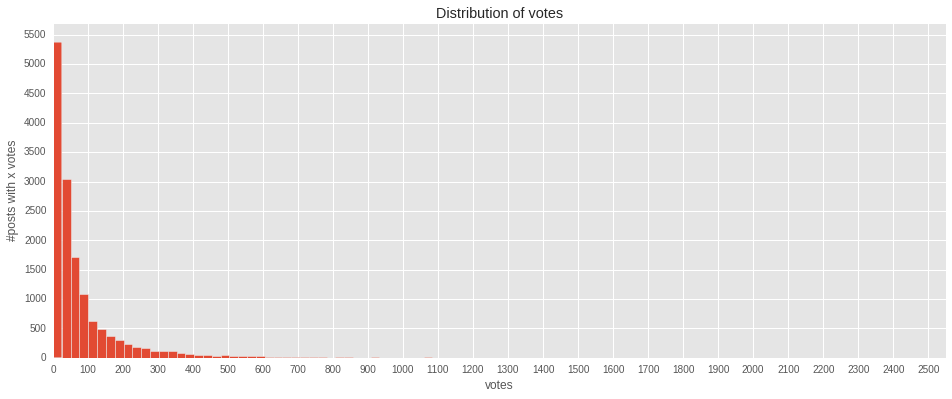

In [67]:
posts['post_votes'].hist(figsize=(16, 6), 
                      bins=100)

plt.title('Distribution of votes')
plt.xlabel('votes')
plt.ylabel('#posts with x votes')
plt.xlim(0,2550)
plt.ylim(0,5700)
plt.xticks(np.arange(0,2550, 100))
plt.yticks(np.arange(0,5600, 500))
plt.show()

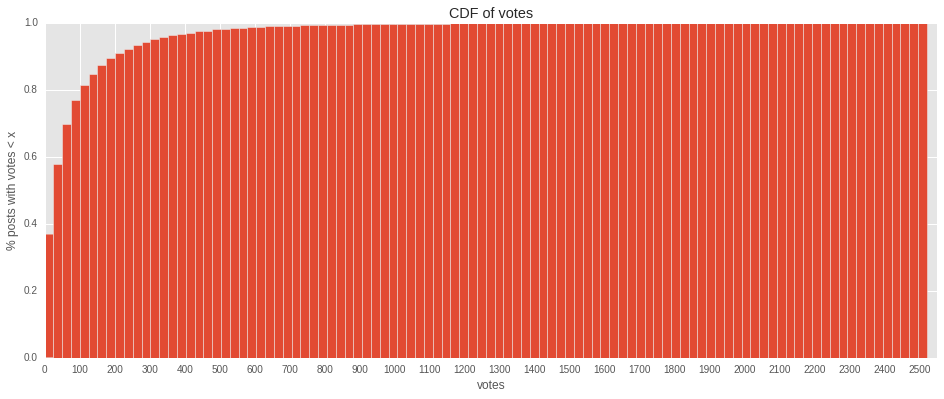

In [68]:
posts['post_votes'].hist(cumulative=True, 
                         normed=1, 
                         bins=100, 
                         figsize=(16, 6))

plt.title('CDF of votes')
plt.xlabel('votes')
plt.ylabel('% posts with votes < x')
plt.xticks(np.arange(0,2550, 100))
plt.xlim(0,2550)
plt.show()

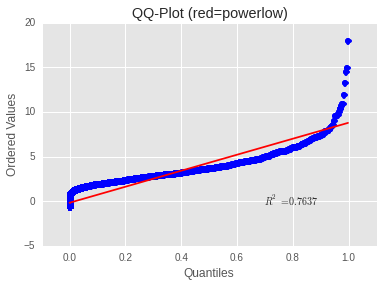

In [69]:
normalizedVotes = (posts['post_votes'].values-np.mean(posts['post_votes'].values))/np.std(posts['post_votes'].values)

stats.probplot(normalizedVotes,
               dist=stats.distributions.powerlaw(0.02), 
               plot=plt)

plt.title('QQ-Plot (red=powerlow)')
plt.xlim(-0.1,1.1)
plt.show()

###Posts with #votes<500

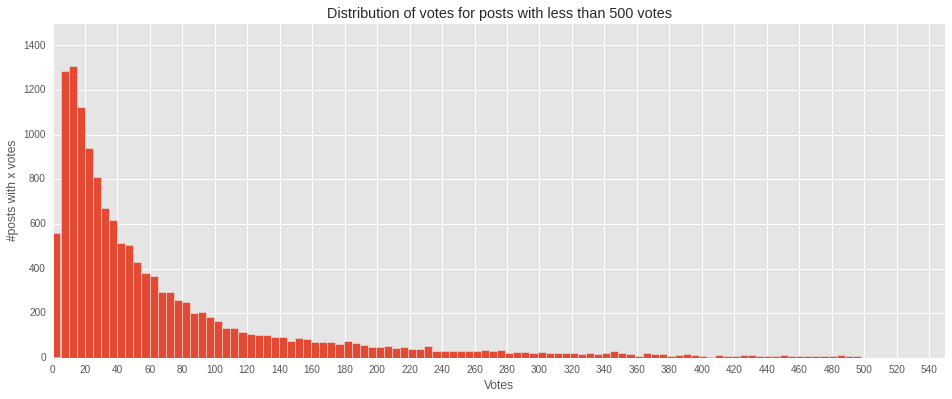

In [70]:
posts['post_votes'][posts.post_votes<500].hist(bins=100, 
                                               figsize=(16, 6))

plt.title('Distribution of votes for posts with less than 500 votes')
plt.xlabel('Votes')
plt.ylabel('#posts with x votes')
plt.xlim(0,550)
plt.ylim(0,1500)
plt.xticks(np.arange(0,550, 20))
plt.show()

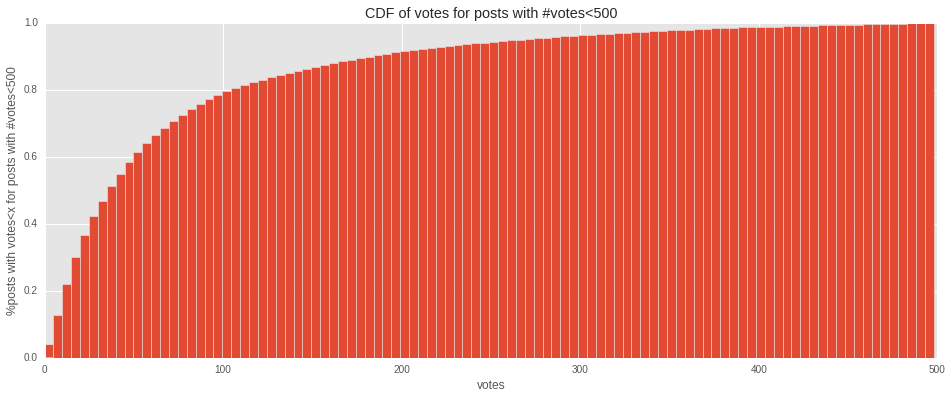

In [71]:
posts['post_votes'][posts.post_votes<500].hist(cumulative=True, 
                                               normed=1, 
                                               bins=100, 
                                               figsize=(16, 6))

plt.title('CDF of votes for posts with #votes<500')
plt.xlabel('votes')
plt.ylabel('%posts with votes<x for posts with #votes<500')
plt.show()

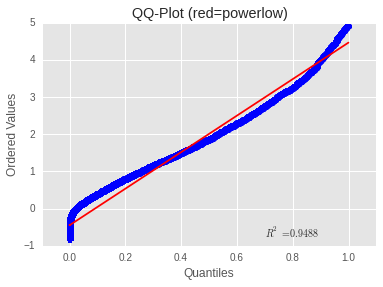

In [72]:
votes500 = posts['post_votes'][posts.post_votes<500].values
normalizedVotes500 = (votes500-np.mean(votes500))/np.std(votes500)

stats.probplot(normalizedVotes500, 
               dist=stats.distributions.powerlaw(0.1), 
               plot=plt)

plt.title('QQ-Plot (red=powerlow)')
plt.xlim(-0.1,1.1)
plt.show()

#  
##Comments

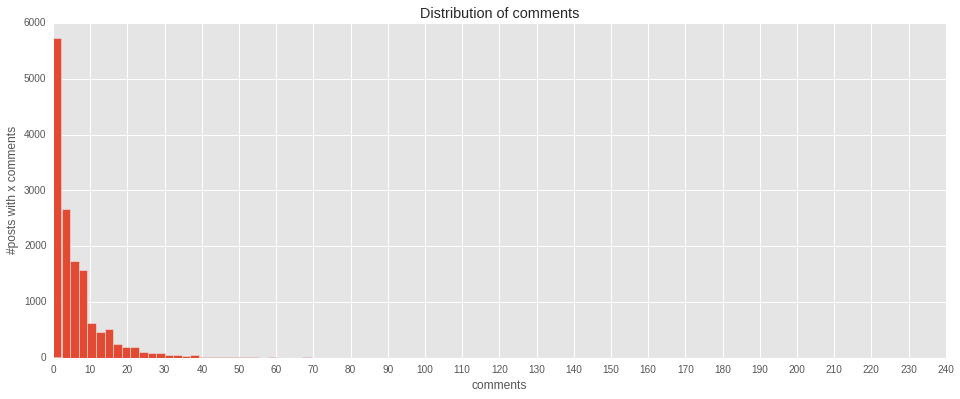

In [73]:
posts['post_comments'].hist(bins=100, 
                            figsize=(16, 6))

plt.title('Distribution of comments')
plt.xlabel('comments')
plt.ylabel('#posts with x comments')
plt.xlim(0,240)
plt.ylim(0,6000)
plt.xticks(np.arange(0,250, 10))
plt.show()

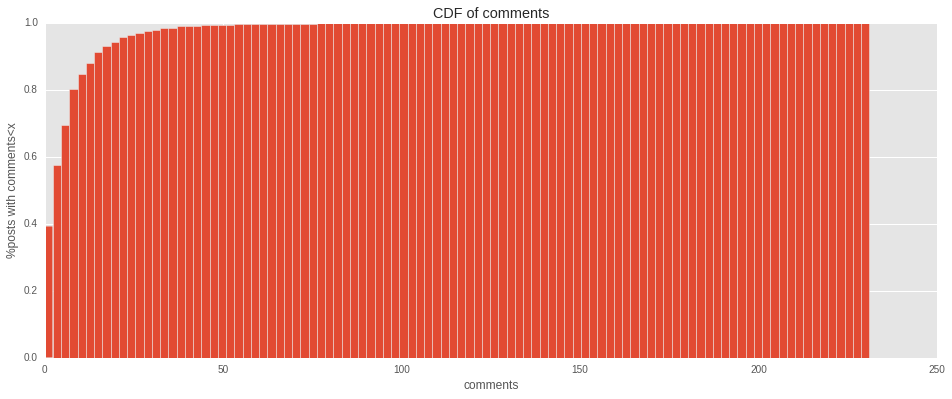

In [74]:
posts['post_comments'].hist(cumulative=True, 
                            normed=1, 
                            bins=100, 
                            figsize=(16, 6))

plt.title('CDF of comments')
plt.xlabel('comments')
plt.ylabel('%posts with comments<x')
plt.show()

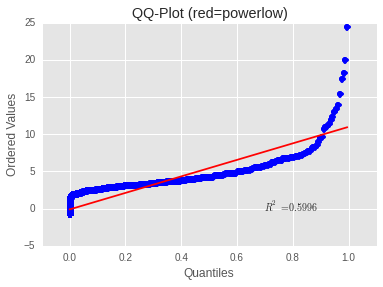

In [75]:
comments = posts['post_comments'].values
normalizedComments = (comments-np.mean(comments))/np.std(comments)

stats.probplot(normalizedComments,
               dist=stats.distributions.powerlaw(0.01), 
               plot=plt)

plt.title('QQ-Plot (red=powerlow)')
plt.xlim(-0.1,1.1)
plt.show()

###Comments for posts with #comments<50

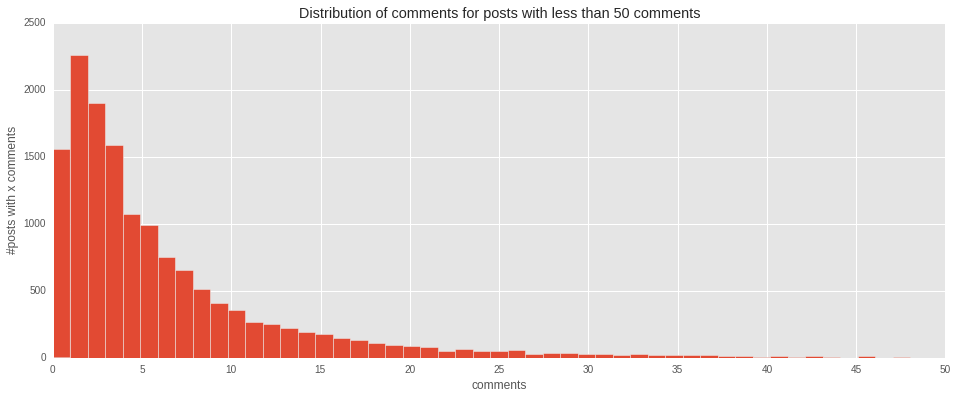

In [76]:
posts['post_comments'][posts.post_comments<50].hist(bins=50, 
                                                    figsize=(16, 6))



plt.title('Distribution of comments for posts with less than 50 comments')
plt.xlabel('comments')
plt.ylabel('#posts with x comments')
plt.xticks(np.arange(0,55, 5))
plt.show()

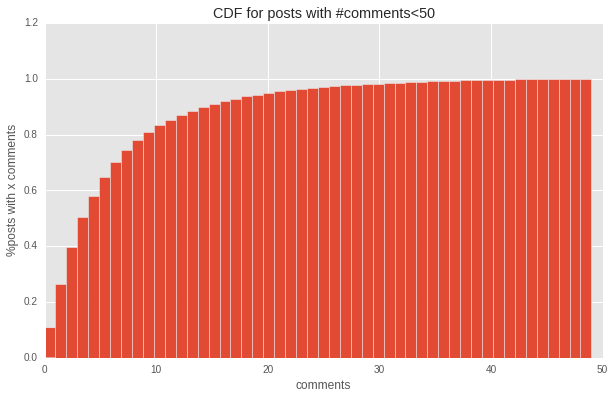

In [77]:
posts['post_comments'][posts.post_comments<50].hist(cumulative=True, 
                                                    normed=1, 
                                                    bins=50, 
                                                    figsize=(10, 6))
plt.title('CDF for posts with #comments<50')
plt.xlabel('comments')
plt.ylabel('%posts with x comments')
plt.show()

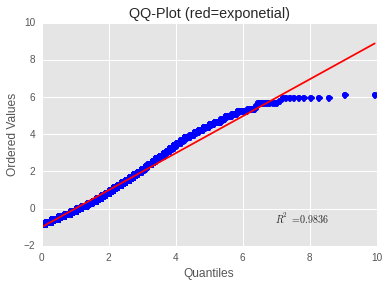

In [78]:
comments50 = posts['post_comments'][posts.post_comments<50].values
normalizedComments50 = (comments50-np.mean(comments50))/np.std(comments50)

stats.probplot(normalizedComments50, 
               dist=stats.distributions.expon,
               plot=plt)

plt.title('QQ-Plot (red=exponetial)')
plt.show()

# 
# 
# 
# 

#Relationship between comments and votes  
###more comments = more votes?

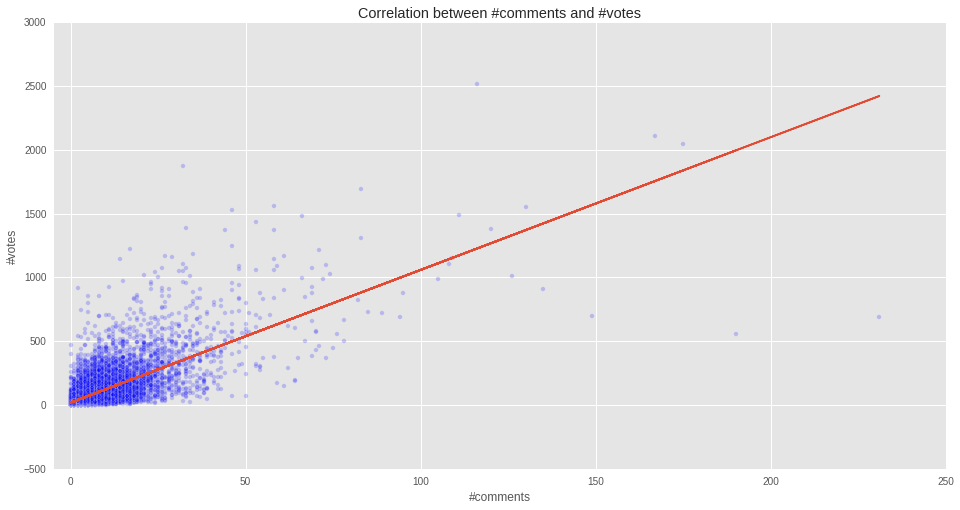

In [79]:
plt.figure(figsize=(16,8))

X = [[x] for x in posts['post_comments'].values]
Y = [[y] for y in posts['post_votes'].values]
plt.scatter(X,Y,alpha=0.2)

#let's draw the regression line
regresssor = linear_model.LinearRegression()
regresssor.fit(X,Y)
plt.plot(X,regresssor.predict(X))

plt.xlim(-5, 250)
plt.title('Correlation between #comments and #votes')
plt.xlabel('#comments')
plt.ylabel('#votes')
plt.show()

###Let's "stratify" the number of comments

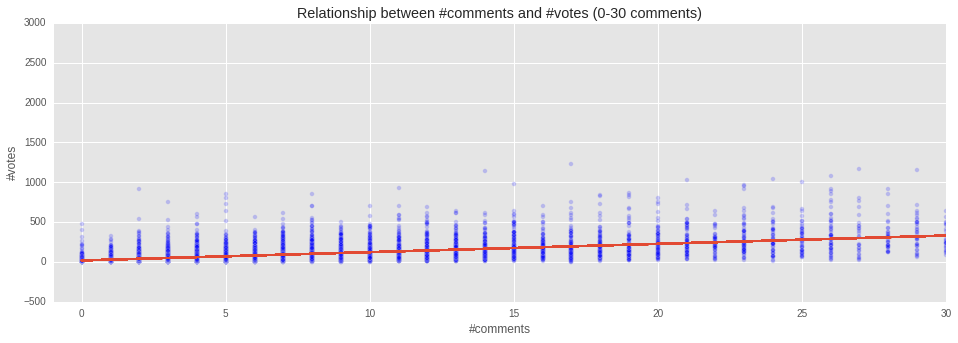

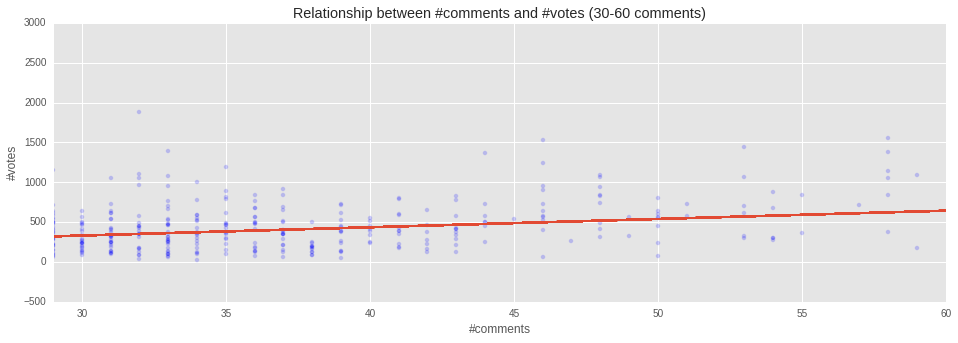

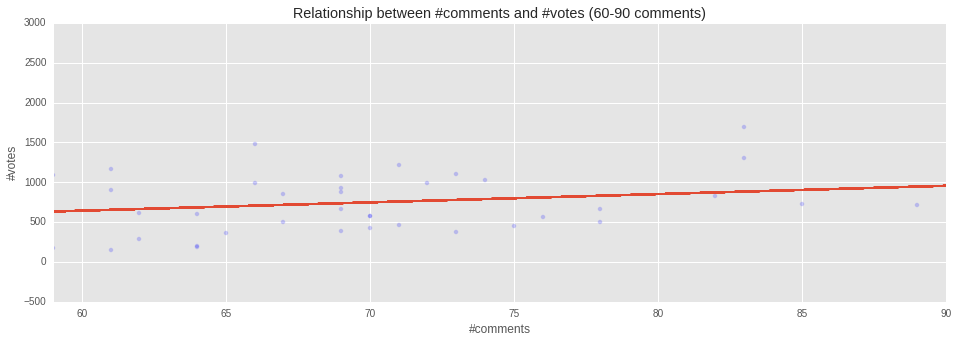

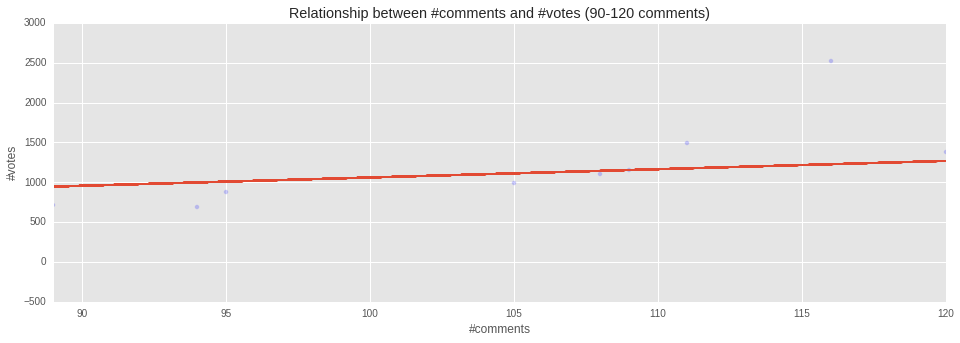

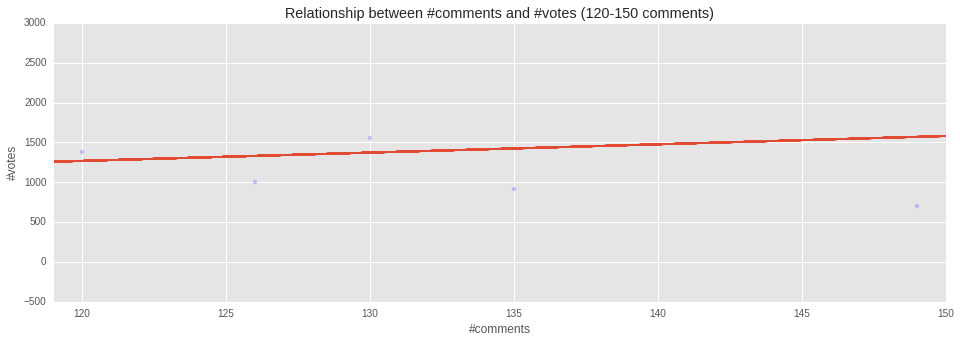

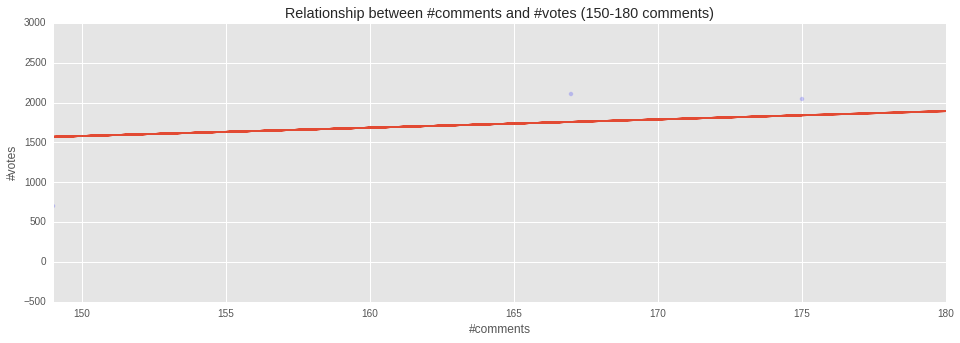

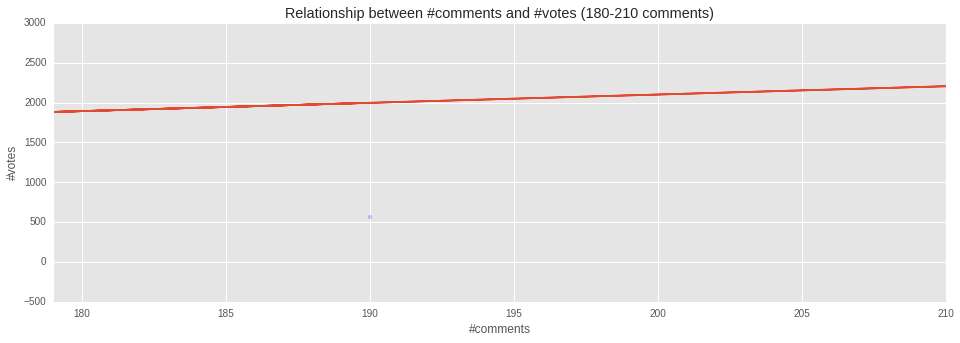

In [80]:
interval = 30
maxComments = max(posts['post_comments'].values)
for comments in np.arange(interval, maxComments+1, interval):
    plt.figure(figsize=(16,5))
    
    X = [[x] for x in posts['post_comments'].values]
    Y = [[y] for y in posts['post_votes'].values]
    plt.scatter(X,Y,alpha=0.2)

    #let's draw the regression line
    regresssor = linear_model.LinearRegression()
    regresssor.fit(X,Y)
    plt.plot(X,regresssor.predict(X))

    plt.xlim(comments-interval-1, comments)

    plt.title('Relationship between #comments and #votes (%d-%d comments)' %(comments-interval, comments))
    plt.xlabel('#comments')
    plt.ylabel('#votes')
    plt.show()

###Let's consider only posts with 20+ votes

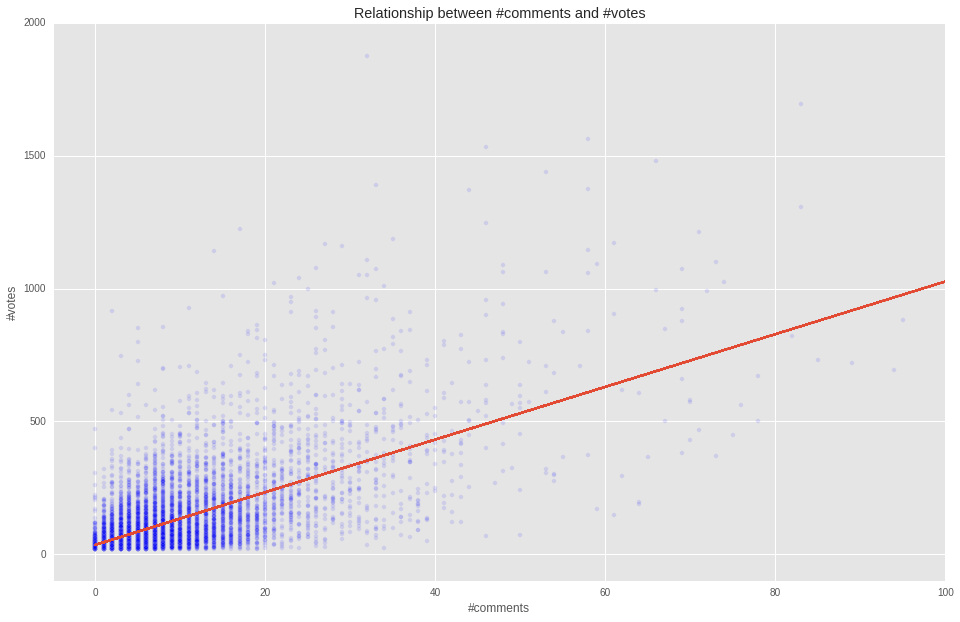

In [81]:
plt.figure(figsize=(16,10))

postsMin20Votes = posts[posts.post_votes>=20]
X = [[x] for x in postsMin20Votes['post_comments'].values]
Y = [[y] for y in postsMin20Votes['post_votes'].values]
plt.scatter(X,Y,alpha=0.1)

#let's draw the regression line
regresssor = linear_model.LinearRegression()
regresssor.fit(X,Y)
plt.plot(X,regresssor.predict(X))

plt.xlim(-5, 100)
plt.ylim(-100, 2000)
plt.title('Relationship between #comments and #votes')
plt.xlabel('#comments')
plt.ylabel('#votes')
plt.show()

###Let's draw correlation between 300 random posts

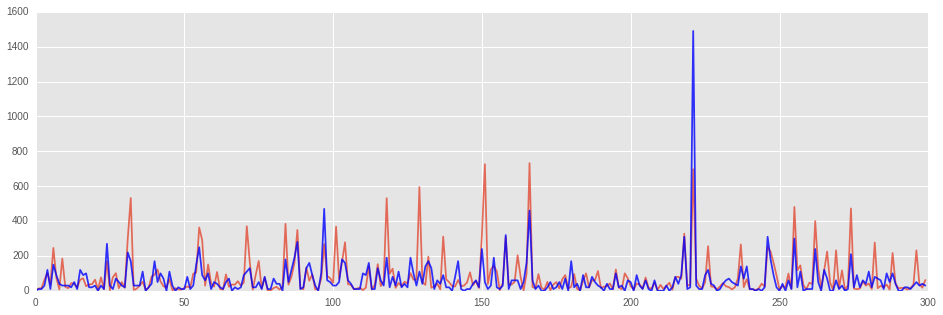

In [82]:
plt.figure(figsize=(16,5))

randomPosts = posts.iloc[random.sample(range(1, len(posts)), 300)]

X = [[x] for x in range(len(randomPosts))]
Y1 = [[y] for y in randomPosts['post_votes'].values]
plt.plot(X,Y1,alpha=0.8)


Y2 = [[y*10] for y in randomPosts['post_comments'].values]
plt.plot(X,Y2,alpha=0.8, c='b')


plt.show()

###Let's get the correlation coefficent

In [83]:
np.corrcoef(randomPosts['post_votes'].values, 
            randomPosts['post_comments'].values)[0, 1]

0.64582836697574819

###Answer###  
It seems there is a linear correlation between #comments and #votes.  
But correlation doesn't imply causation so we can't say "comment more to have more votes".

# 
# 
# 
# 

#When do people post/comment the more?

###Posts - day of the week

In [84]:
postsPerDayOfWeek_total = posts[['occ', 'post_data_weekday']].groupby('post_data_weekday').count().reset_index()
postsPerDayOfWeek_total

,post_data_weekday,occ
0,0,2269
1,1,2671
2,2,2802
3,3,2741
4,4,2179
5,5,981
6,6,906


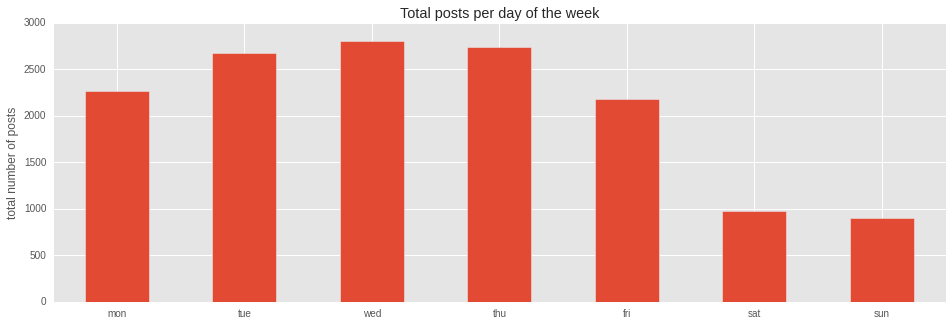

In [85]:
postsPerDayOfWeek_total['occ'].plot(kind='bar',figsize=(16, 5))

plt.xticks(range(0,7), 
           ['mon','tue','wed','thu','fri','sat','sun'], 
           rotation=0)
plt.xlabel('')
plt.ylabel('total number of posts')

plt.title('Total posts per day of the week')
plt.show()

In [86]:
# for each week
# for each day
# get the number of posts
postsPerDayOfWeek_count = posts[['post_data_week_unique', 'post_data_weekday', 'occ']].groupby(['post_data_week_unique', 'post_data_weekday']).sum().reset_index()
postsPerDayOfWeek_count.sort(['post_data_week_unique', 'post_data_weekday']).head()

,post_data_week_unique,post_data_weekday,occ
0,201301,0,13
1,201301,1,13
2,201347,6,1
3,201348,0,1
4,201348,1,1


In [87]:
#let' mean them
postsPerDayOfTheWeek_mean = postsPerDayOfWeek_count[['post_data_weekday','occ']].groupby('post_data_weekday').mean().reset_index()
postsPerDayOfTheWeek_mean

,post_data_weekday,occ
0,0,29.089744
1,1,34.243590
2,2,36.389610
3,3,35.141026
4,4,27.935897
5,5,12.576923
6,6,11.615385


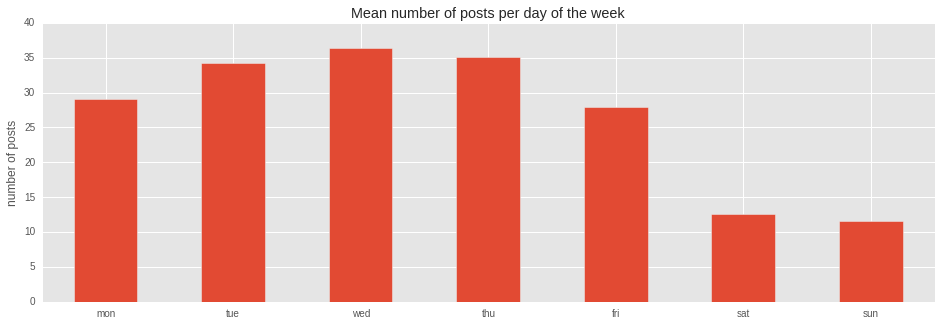

In [88]:
plt.figure(figsize=(16, 5), dpi=300)

postsPerDayOfTheWeek_mean['occ'].plot(kind='bar')

plt.xticks(range(0,7), ['mon','tue','wed','thu','fri','sat','sun'], rotation=0)
plt.title('Mean number of posts per day of the week')
plt.ylabel('number of posts')
plt.show()

###Posts - hour

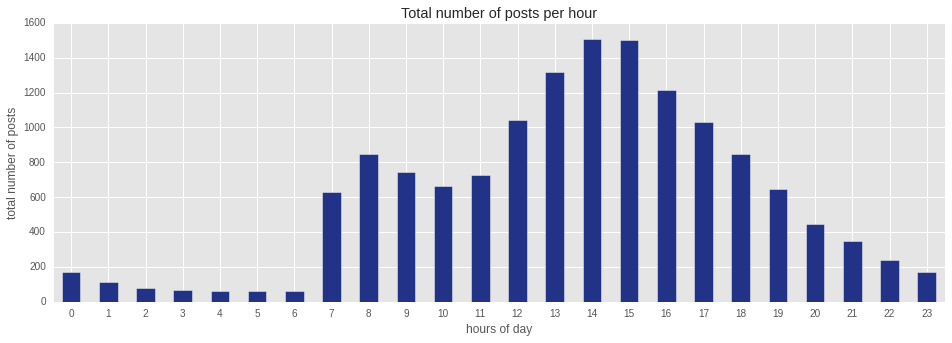

In [89]:
posts[['occ', 'post_data_hour']].groupby('post_data_hour').count().plot(kind='bar', 
                                                                        figsize=(16, 5),
                                                                        legend=False,
                                                                        color='#223387')

plt.xticks(rotation=0)
plt.xlabel('hours of day')
plt.ylabel('total number of posts')
plt.title('Total number of posts per hour')
plt.show()

###Posts - hour (posts with +300 votes)

In [90]:
postsPerHour_300votes_total = posts[posts.post_votes>=300][['occ', 'post_data_hour']].groupby('post_data_hour').count().reset_index()
postsPerHour_300votes_total.head()

,post_data_hour,occ
0,0,1
1,2,2
2,4,1
3,5,1
4,7,58


In [91]:
# some hours has no posts with +300 votes 
# so I have to add those hours
for i in range(0, 24):
    if i not in postsPerHour_300votes_total.values[:,0]:
        position = len(postsPerHour_300votes_total)
        postsPerHour_300votes_total.loc[position, 'post_data_hour'] = int(i)
        postsPerHour_300votes_total.loc[position, 'occ'] = 0
len(postsPerHour_300votes_total)

24

In [92]:
postsPerHour_300votes_total = postsPerHour_300votes_total[['post_data_hour','occ']].sort('post_data_hour')
postsPerHour_300votes_total.head()

,post_data_hour,occ
0,0,1
21,1,0
1,2,2
22,3,0
2,4,1


In [93]:
postsPerHour_300votes_total.post_data_hour = [int(i) for i in list(postsPerHour_300votes_total.post_data_hour)] #to remove floats
postsPerHour_300votes_total.dtypes

post_data_hour      int64
occ               float64
dtype: object

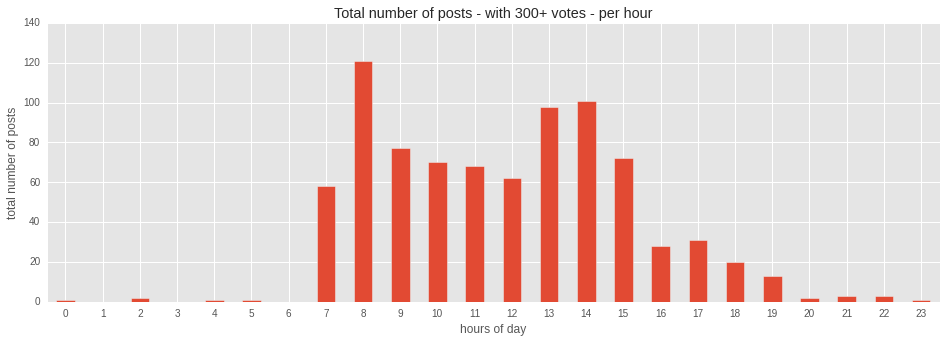

In [97]:
postsPerHour_300votes_total.plot(kind='bar', 
                                 x='post_data_hour', 
                                 y='occ',
                                 figsize=(16, 5),
                                 legend=False)
plt.xticks(rotation=0)
#plt.xticks(np.arange(0,24, 1), np.arange(0,24, 1))
plt.xlabel('hours of day')
plt.ylabel('total number of posts')
plt.title('Total number of posts - with 300+ votes - per hour')
plt.show()

###Post - timeslot (week+hour)

In [98]:
# for every day
# (keeping the weekday)
# for every hour
# count the number of posts
postsPerTimeslot_total = posts[['post_data_date', 'post_data_weekday','post_data_hour', 'occ']].groupby(['post_data_date', 'post_data_weekday','post_data_hour']).sum()
postsPerTimeslot_total.head()

occ
post_data_date post_data_weekday post_data_hour     
2013-11-24     6                 17                1
2013-11-25     0                 6                 1
2013-11-26     1                 23                1
2013-11-27     2                 18                1
                                 19                7

In [99]:
# for every weekday
# for hour
# count the number of posts
postsPerTimeslot_total = postsPerTimeslot_total.reset_index()[['post_data_weekday','post_data_hour', 'occ']].groupby(['post_data_weekday','post_data_hour']).sum()
postsPerTimeslot_total.head()

occ
post_data_weekday post_data_hour     
0                 0                20
                  1                12
                  2                12
                  3                12
                  4                 6

In [100]:
postsPerTimeslot_total = postsPerTimeslot_total.reset_index()

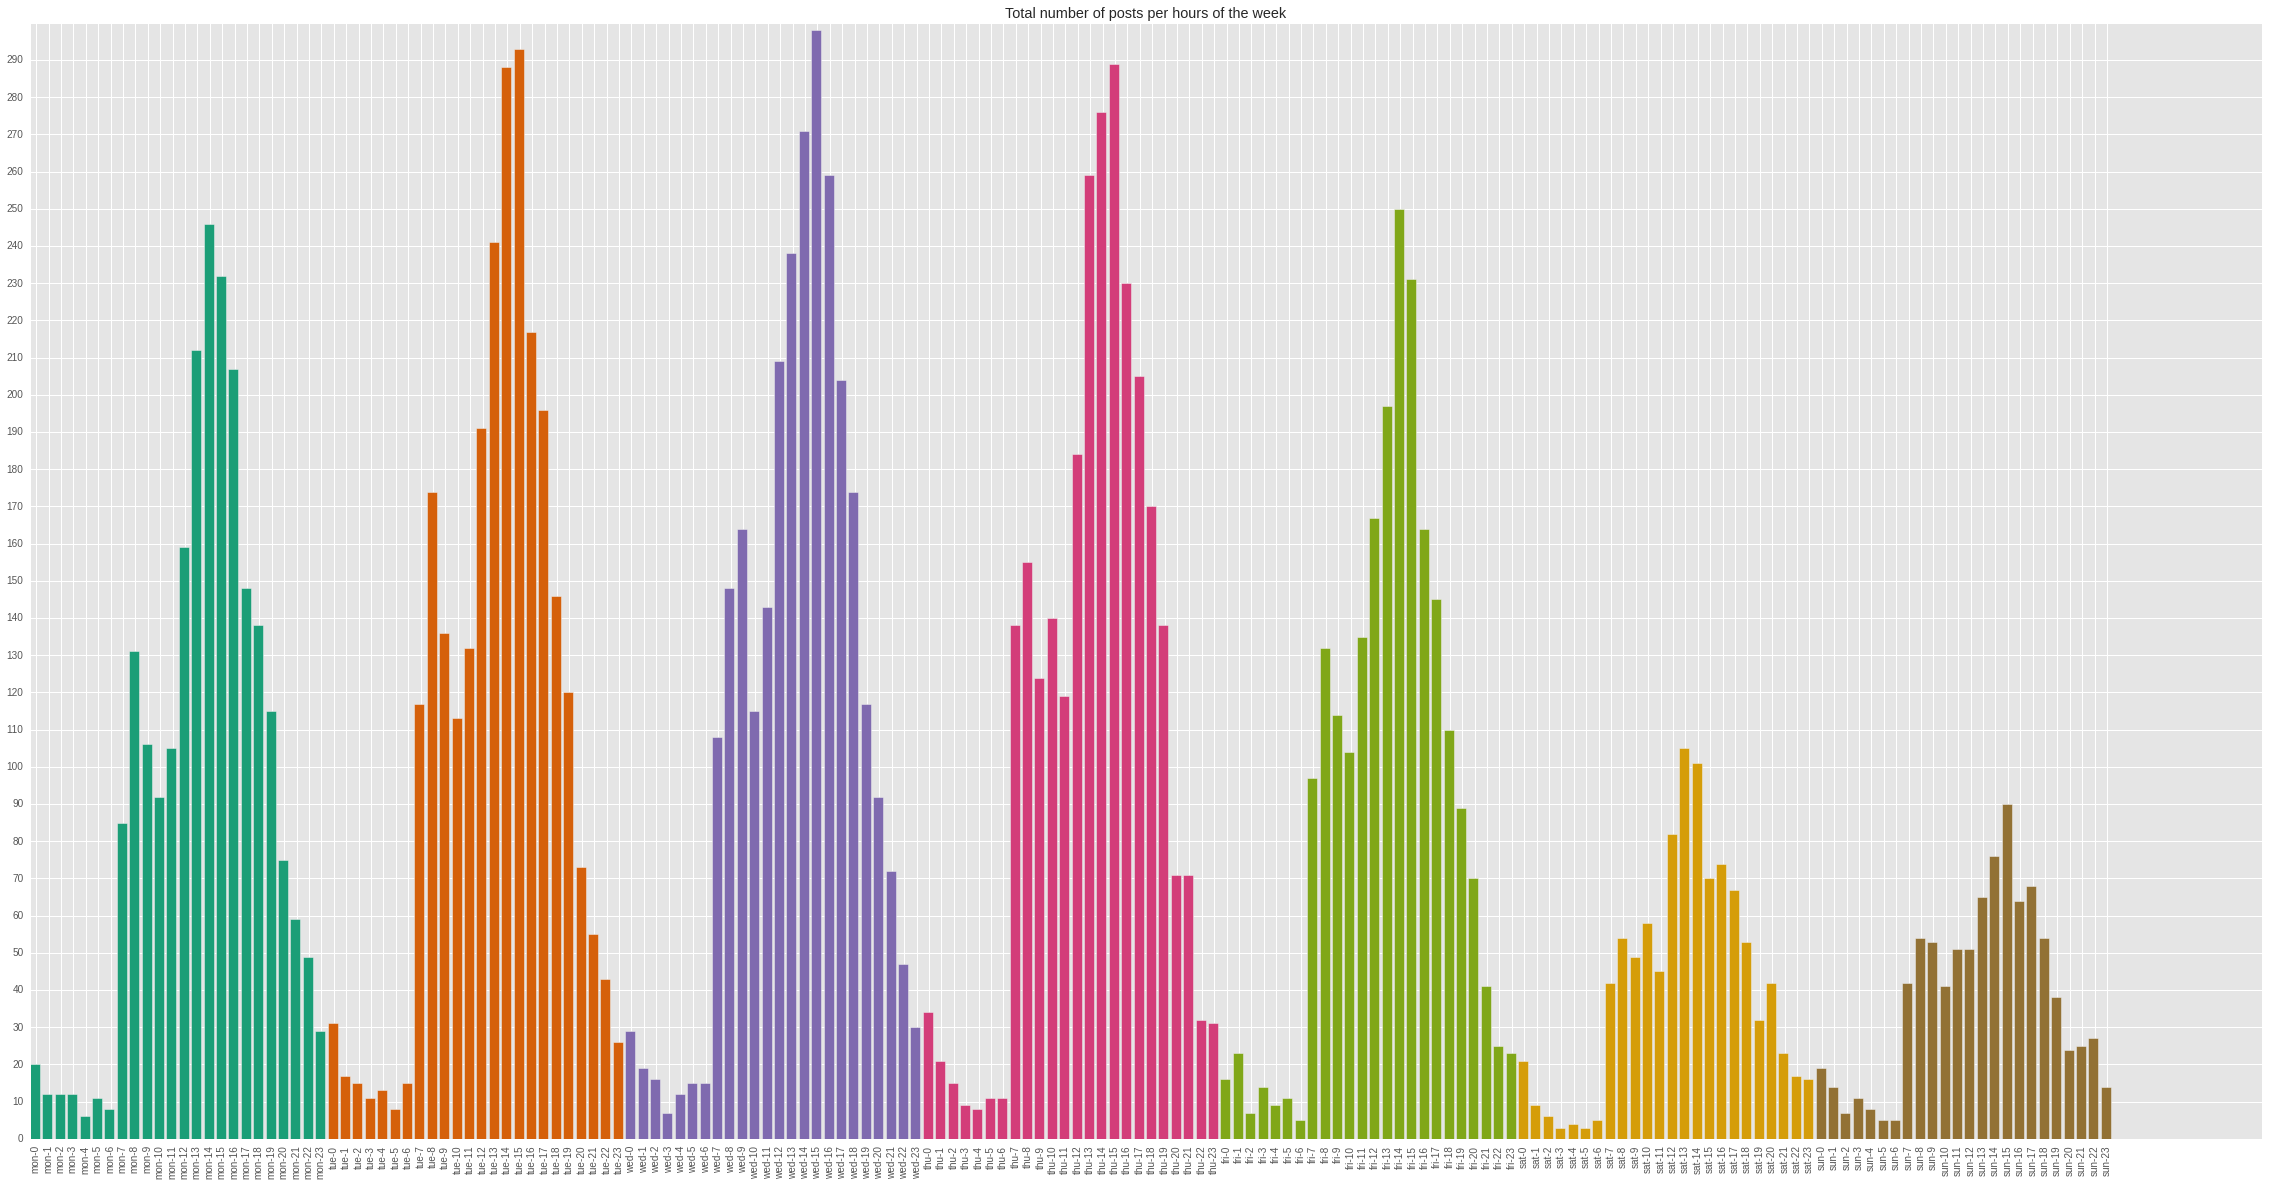

In [101]:
plt.figure(figsize=(40, 20), dpi=600)


plt.bar(range(len(postsPerTimeslot_total)),
        postsPerTimeslot_total['occ'],
        color=cm.Dark2([0.15*x for x in postsPerTimeslot_total['post_data_weekday'].values]))


plt.title('Total number of posts per hours of the week')
plt.xticks(np.arange(0.5,len(postsPerTimeslot_total),1), 
           [x[0]+str(x[1]) for x in list(itertools.product(*[['mon-','tue-','wed-','thu-','fri-','sat-','sun-'],range(24)]))], 
           rotation=90,
           fontsize=10)

plt.xticks(np.arange(0.5,len(postsPerTimeslot_total),1), 
           [x[0]+str(x[1]) for x in list(itertools.product(*[['mon-','tue-','wed-','thu-','fri-','sat-','sun-'],range(24)]))], 
           rotation=90,
           fontsize=10)

plt.yticks(np.arange(0,300,10))

plt.savefig('img/totPosts.png')
plt.show()

#  
##Relation between post pubblication day/hour and number of votes

####Weekday

In [102]:
postsPerWeek_mean = posts[['post_data_weekday', 'post_votes']].groupby(['post_data_weekday']).mean()
postsPerWeek_mean.head()

,post_votes
post_data_weekday,
0,83.268841
1,90.022463
2,81.442898
3,85.431594
4,79.304727


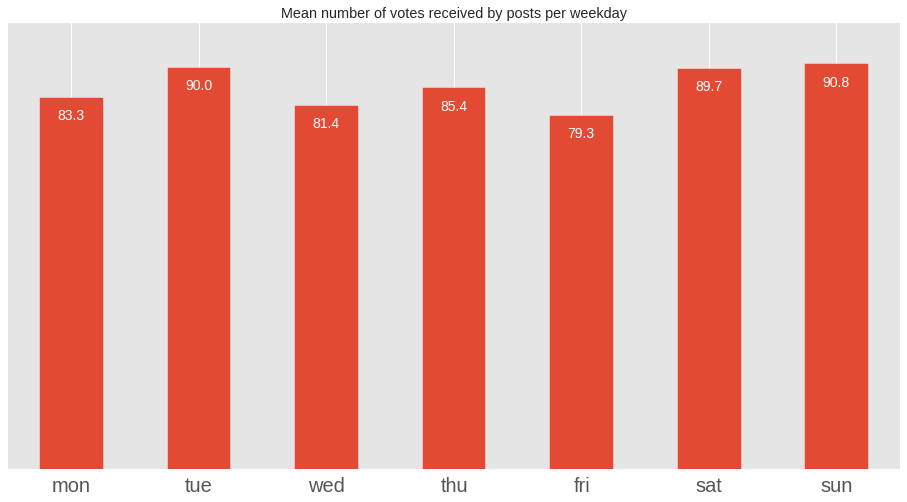

In [104]:
postsPerWeek_mean.plot(kind='bar',
                         figsize=(16, 8),
                         legend=False,
                         yticks=[],
                         grid=None)

for i in range(len(postsPerWeek_mean)):
    day = postsPerWeek_mean.index.values[i]
    value = postsPerWeek_mean.post_votes.values[i]
    plt.text(day-0.1, value-5, str(round(value,1)), fontsize=14, color='white')

plt.xticks(np.arange(0,7,1), ['mon','tue','wed','thu','fri','sat','sun'], 
           rotation=0,
           fontsize=20)

plt.title('Mean number of votes received by posts per weekday')
plt.xlabel('')
plt.show()

###hour

In [107]:
#for every day
#for every hour
#get the mean of comments per post

votesOfPostsPerHour = posts[['post_data_date', 'post_data_hour', 'post_votes']].groupby(['post_data_date', 'post_data_hour']).mean()
votesOfPostsPerHour.head(10)

post_votes
post_data_date post_data_hour            
2013-11-24     17                4.000000
2013-11-25     6                 1.000000
2013-11-26     23               49.000000
2013-11-27     18               66.000000
               19               15.857143
               21               11.000000
               22                3.000000
               23               13.000000
2013-11-28     0                 7.000000
               1                 5.000000

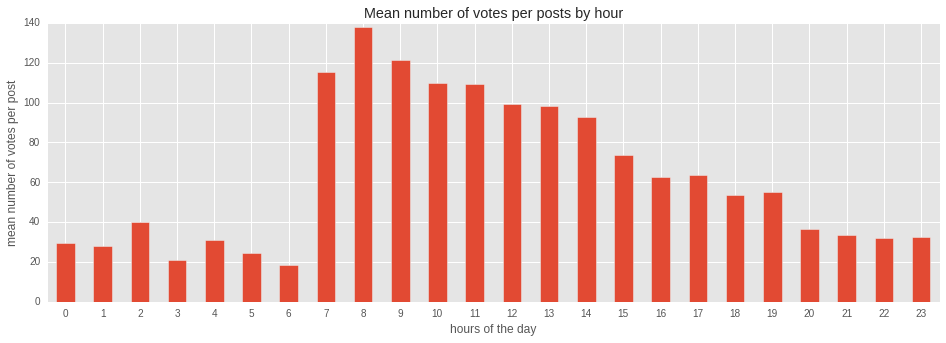

In [108]:
votesOfPostsPerHour.reset_index()[['post_data_hour', 'post_votes']].groupby('post_data_hour').mean().plot(kind='bar', 
                                                                                                          figsize=(16,5),
                                                                                                          legend=False)

plt.xticks(rotation=0)
plt.title('Mean number of votes per posts by hour')
plt.ylabel('mean number of votes per post')
plt.xlabel('hours of the day')
plt.show()

##What is the best hour of the week to post? (maybe 8 of wednsday?)

In [109]:
#for every day
#for every day of the week
#for every hour
#get the mean of comments per post

votesOfPostsPerHour = posts[['post_data_date', 'post_data_weekday','post_data_hour', 'post_votes']].groupby(['post_data_date', 'post_data_weekday','post_data_hour']).mean()
votesOfPostsPerHour.head()

post_votes
post_data_date post_data_weekday post_data_hour            
2013-11-24     6                 17                4.000000
2013-11-25     0                 6                 1.000000
2013-11-26     1                 23               49.000000
2013-11-27     2                 18               66.000000
                                 19               15.857143

In [110]:
weekDayAndHours2PostVotesMeans = votesOfPostsPerHour.reset_index()[['post_data_weekday','post_data_hour', 'post_votes']].groupby(['post_data_weekday','post_data_hour']).mean()
weekDayAndHours2PostVotesMeans = weekDayAndHours2PostVotesMeans.reset_index()
weekDayAndHours2PostVotesMeans.rename(columns={'post_votes': 'post_votes_mean'}, inplace=True)
weekDayAndHours2PostVotesMeans.head()

,post_data_weekday,post_data_hour,post_votes_mean
0,0,0,40.789474
1,0,1,33.611111
2,0,2,80.181818
3,0,3,28.863636
4,0,4,35.833333


In [111]:
weekDayAndHours2PostVotesSDs = votesOfPostsPerHour.reset_index()[['post_data_weekday','post_data_hour', 'post_votes']].groupby(['post_data_weekday','post_data_hour']).std()
weekDayAndHours2PostVotesSDs = weekDayAndHours2PostVotesSDs.reset_index()
weekDayAndHours2PostVotesSDs.rename(columns={'post_votes': 'post_votes_sd'}, inplace=True)
weekDayAndHours2PostVotesSDs.head()

,post_data_weekday,post_data_hour,post_votes_sd
0,0,0,53.511763
1,0,1,18.246194
2,0,2,138.649788
3,0,3,10.904336
4,0,4,24.293346


In [112]:
weekDayAndHours2PostVotes = weekDayAndHours2PostVotesMeans.merge(weekDayAndHours2PostVotesSDs, on=['post_data_weekday','post_data_hour'])
weekDayAndHours2PostVotes.head()

,post_data_weekday,post_data_hour,post_votes_mean,post_votes_sd
0,0,0,40.789474,53.511763
1,0,1,33.611111,18.246194
2,0,2,80.181818,138.649788
3,0,3,28.863636,10.904336
4,0,4,35.833333,24.293346


### Means are useless if too few posts are used so let's select only weekday+hour if #posts>200

In [113]:
#combination of weekday+hour where 200+ posts have been posted
postsPerTimeslot_total_200 = postsPerTimeslot_total[postsPerTimeslot_total.occ>=200].reset_index()
postsPerTimeslot_total_200.head()

,index,post_data_weekday,post_data_hour,occ
0,13,0,13,212
1,14,0,14,246
2,15,0,15,232
3,16,0,16,207
4,37,1,13,241


In [114]:
#let's make a join to get means and STDs
postsPerTimeslot_total_200 = postsPerTimeslot_total_200.merge(weekDayAndHours2PostVotes, on=['post_data_weekday','post_data_hour'])
postsPerTimeslot_total_200.sort('post_votes_mean', ascending=False, inplace=True)
postsPerTimeslot_total_200

,index,post_data_weekday,post_data_hour,occ,post_votes_mean,post_votes_sd
4,37,1,13,241,111.962909,89.451193
14,85,3,13,259,105.032691,92.670681
5,38,1,14,288,99.188416,87.491454
8,60,2,12,209,98.938255,93.762282
15,86,3,14,276,95.099951,136.197932
6,39,1,15,293,94.381623,85.071322
0,13,0,13,212,92.050818,81.853191
10,62,2,14,271,90.647803,79.642625
1,14,0,14,246,90.506149,83.140076
16,87,3,15,289,85.148927,94.558452


In [115]:
day2string = {0:'mon',
              1:'tue',
              2:'wed',
              3:'thu',
              4:'fri',
              5:'sat',
              6:'sun',}

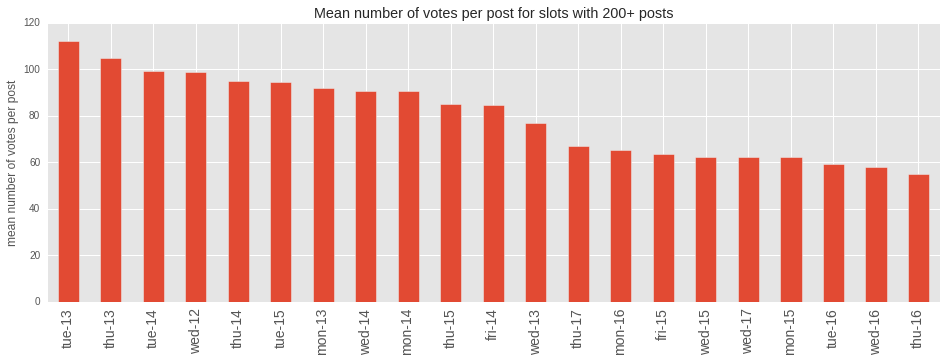

In [116]:
postsPerTimeslot_total_200.plot(kind='bar',
                                           y='post_votes_mean', 
                                           x='post_data_hour',
                                           figsize=(16,5),
                                           legend=False)


plt.xticks(range(len(postsPerTimeslot_total_200)),
           [day2string[postsPerTimeslot_total_200['post_data_weekday'].values[i]]+'-'+str(postsPerTimeslot_total_200['post_data_hour'].values[i]) for i in range(len(postsPerTimeslot_total_200))],
          fontsize=14)


plt.title('Mean number of votes per post for slots with 200+ posts')
plt.xlabel('')
plt.ylabel('mean number of votes per post')
plt.show()

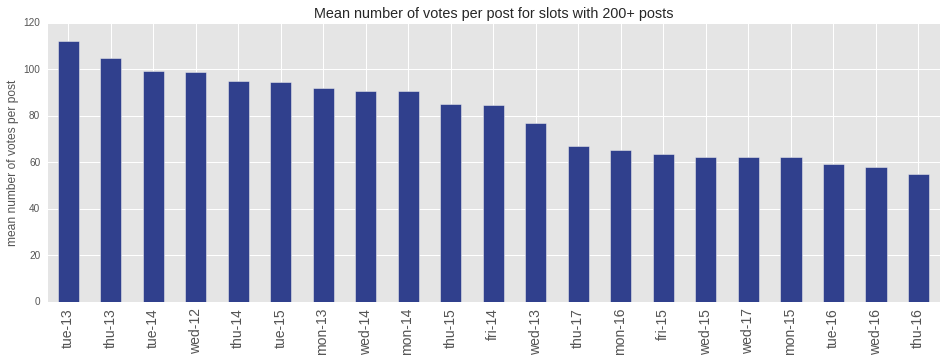

In [117]:
postsPerTimeslot_total_200.plot(kind='bar',
                                           y='post_votes_mean', 
                                           x='post_votes_sd',
                                           figsize=(16,5),
                                           legend=False,
                                           color='#30408d')


plt.xticks(range(len(postsPerTimeslot_total_200)),
           [day2string[postsPerTimeslot_total_200['post_data_weekday'].values[i]]+'-'+str(postsPerTimeslot_total_200['post_data_hour'].values[i]) for i in range(len(postsPerTimeslot_total_200))],
          fontsize=14)


plt.title('Mean number of votes per post for slots with 200+ posts')
plt.xlabel('')
plt.ylabel('mean number of votes per post')
plt.show()

### Let's put the previous two graph in a single graph

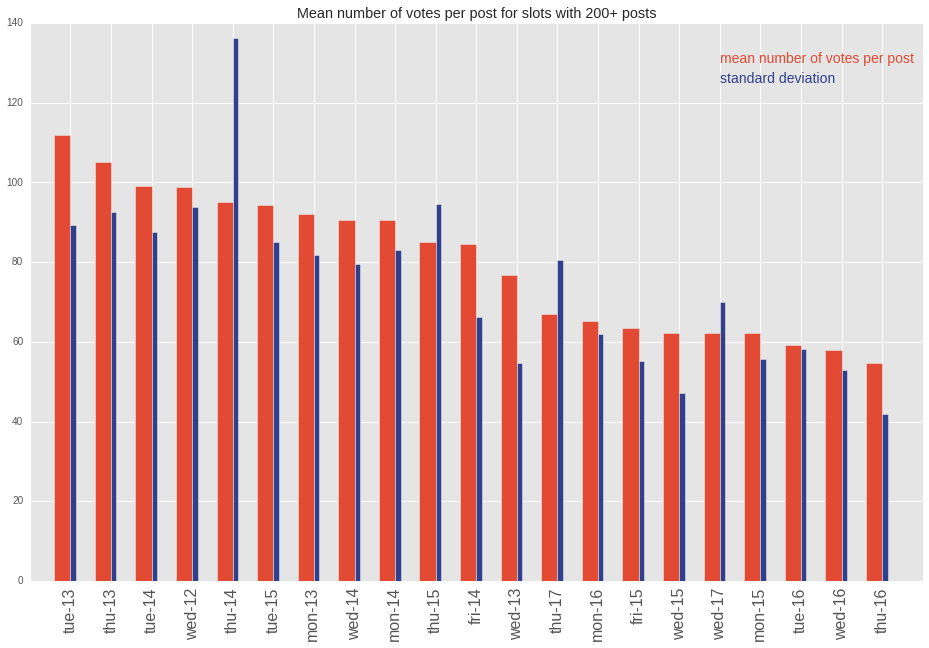

In [118]:
width = 0.4 


plt.figure(figsize=(16, 5), dpi=300)



fig = plt.figure() # Create matplotlib figure
fig.set_size_inches(16, 5)

ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Cr


postsPerTimeslot_total_200.plot(kind='bar',
                                y='post_votes_sd', 
                                x='post_data_hour',
                                figsize=(16,10),position=0,ax=ax2,legend=False,width=width/3.,
                                color='#30408d',label='')

postsPerTimeslot_total_200.plot(kind='bar',
                                y='post_votes_mean', 
                                x='post_data_hour',
                                figsize=(16,10), position=1,ax=ax1,legend=False,width=width,ylim=(0,140),label='')

[tick.label.set_fontsize(16) for tick in ax1.xaxis.get_major_ticks()]
ytickLabels = [day2string[postsPerTimeslot_total_200['post_data_weekday'].values[i]]+'-'+str(postsPerTimeslot_total_200['post_data_hour'].values[i]) for i in range(len(postsPerTimeslot_total_200))]
plt.xticks(range(len(postsPerTimeslot_total_200)),
           ytickLabels)
plt.xlim(-1,21)
  
ax2.set_yticks([])

ax1.text(16, 125, 'standard deviation',color='#30408d', fontsize=14)
ax2.text(16, 130, 'mean number of votes per post',color='#e24a33', fontsize=14)

plt.xlabel('')
plt.title('Mean number of votes per post for slots with 200+ posts')   
plt.show()

# 
# 
# 
# 

#Is PH growing?

##Number of posts per day

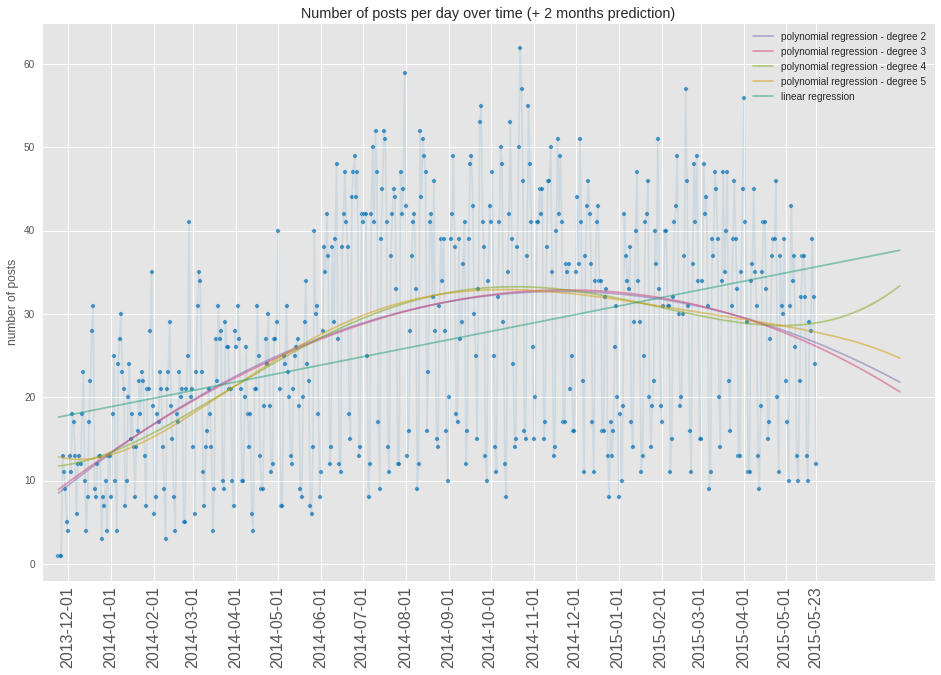

In [119]:
postsPerDate = posts[['post_id', 'post_data_date']].groupby('post_data_date').count().reset_index()
plt.figure(figsize=(16,10))

X = [[i] for i in range(len(postsPerDate))] 
Y = [[x] for x in postsPerDate['post_id']]

plt.scatter(X,Y, c='#006eb4', alpha=0.7)
plt.plot(X,Y, c='#006eb4', alpha=0.1)


#
# POLYNOMIAL REGRESSION - grade 2-5
#
prediction = 60 #days
for degree in range(2,6):
    regresssor = make_pipeline(PolynomialFeatures(degree),Ridge())
    regresssor.fit(X,Y)
    color =  cm.Dark2(0.15*degree)
    
    plt.plot([[i] for i in range(0, len(postsPerDate)+prediction)], 
             regresssor.predict([[i] for i in range(0, len(postsPerDate)+prediction)]), 
             c=color,
             alpha=0.5,
             label='polynomial regression - degree '+str(degree))

    

    
regresssor = linear_model.LinearRegression()
regresssor.fit(X,Y)
plt.plot([[i] for i in range(0, len(postsPerDate)+prediction)], 
             regresssor.predict([[i] for i in range(0, len(postsPerDate)+prediction)]), 
             c=cm.Dark2(0),
             alpha=0.5,
             label='linear regression')

plt.legend()

xlabels = {}
for i in range(0, len(postsPerDate.values)):
    date = str(postsPerDate['post_data_date'].values[i])
    if (date.split('-')[2]=='01') | (i==len(postsPerDate.values)-1):
        xlabels[i] = date
plt.xticks(xlabels.keys(), xlabels.values(), rotation=90, fontsize=16)


plt.ylim(-2,65)
plt.xlim(-12,630)
plt.title('Number of posts per day over time (+ 2 months prediction)')
plt.ylabel('number of posts')
plt.xlabel('')
plt.show()

##number of votes per post per day

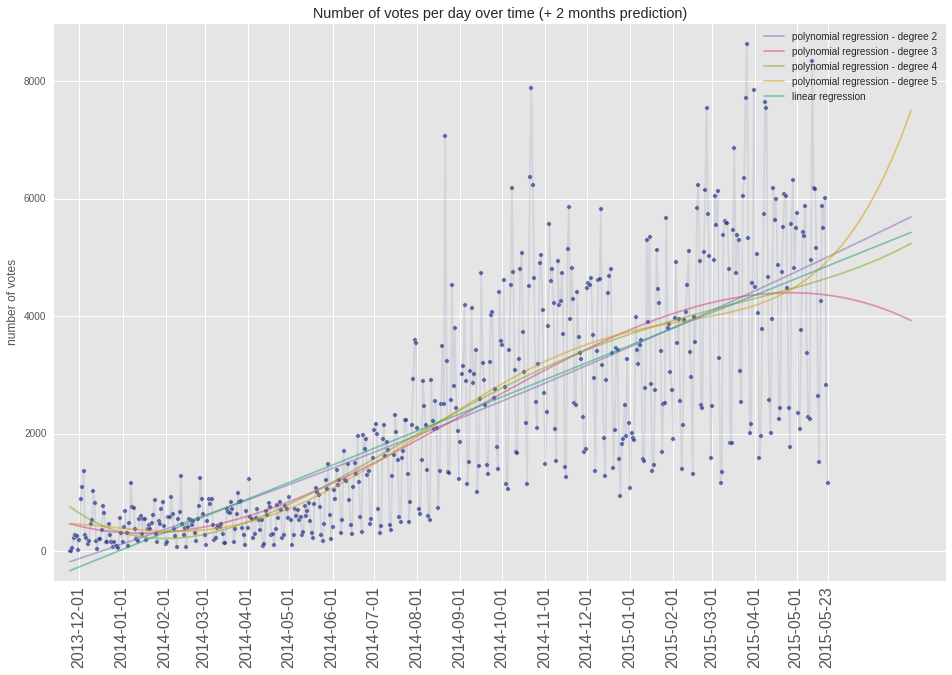

In [120]:
votesPerDay = posts[['post_votes', 'post_data_date']].groupby('post_data_date').sum().reset_index()
plt.figure(figsize=(16,10))

X = [[i] for i in range(len(votesPerDay))] 
Y = [[x] for x in votesPerDay['post_votes']]

plt.scatter(X,Y, c='#223387', alpha=0.7)
plt.plot(X,Y, c='#223387', alpha=0.1)


#
# POLYNOMIAL REGRESSION - grade 2-5
#
prediction = 60 #days
for degree in range(2,6):
    regresssor = make_pipeline(PolynomialFeatures(degree),Ridge())
    regresssor.fit(X,Y)
    color =  cm.Dark2(0.15*degree)
    
    plt.plot([[i] for i in range(0, len(votesPerDay)+prediction)], 
             regresssor.predict([[i] for i in range(0, len(votesPerDay)+prediction)]), 
             c=color,
             alpha=0.5,
             label='polynomial regression - degree '+str(degree))

#linear regression  
regresssor = linear_model.LinearRegression()
regresssor.fit(X,Y)
plt.plot([[i] for i in range(0, len(votesPerDay)+prediction)], 
             regresssor.predict([[i] for i in range(0, len(votesPerDay)+prediction)]), 
             c=cm.Dark2(0),
             alpha=0.5,
             label='linear regression')



xlabels = {}
for i in range(0, len(votesPerDay.values)):
    date = str(postsPerDate['post_data_date'].values[i])
    if (date.split('-')[2]=='01') | (i==len(votesPerDay.values)-1):
        xlabels[i] = date
plt.xticks(xlabels.keys(), xlabels.values(), rotation=90, fontsize=16)
plt.legend()
plt.ylim(-500,9000)
plt.xlim(-12,630)
plt.title('Number of votes per day over time (+ 2 months prediction)')
plt.ylabel('number of votes')
plt.xlabel('')
plt.show()

###total number of votes per day - YC effect?

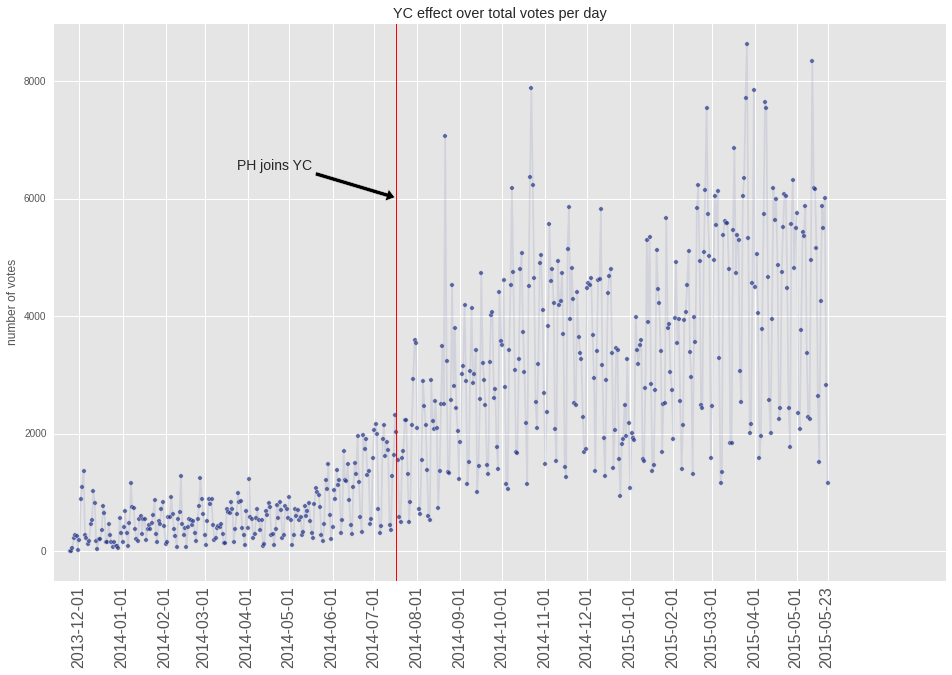

In [121]:
votesPerDay = posts[['post_votes', 'post_data_date']].groupby('post_data_date').sum().reset_index()
plt.figure(figsize=(16,10))

X = [[i] for i in range(len(votesPerDay))] 
Y = [[x] for x in votesPerDay['post_votes']]

plt.scatter(X,Y, c='#223387', alpha=0.7)
plt.plot(X,Y, c='#223387', alpha=0.1)


plt.axvline(235,c='r',linewidth=1)


xlabels = {}
for i in range(0, len(votesPerDay.values)):
    date = str(postsPerDate['post_data_date'].values[i])
    if (date.split('-')[2]=='01') | (i==len(votesPerDay.values)-1):
        xlabels[i] = date
plt.xticks(xlabels.keys(), xlabels.values(), rotation=90, fontsize=16)

plt.annotate('PH joins YC', xy=(237, 6000), xytext=(120, 6500), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylim(-500,9000)
plt.xlim(-12,630)
plt.title('YC effect over total votes per day')
plt.ylabel('number of votes')
plt.xlabel('')
plt.show()

###mean number of votes per post per day - YC effect?

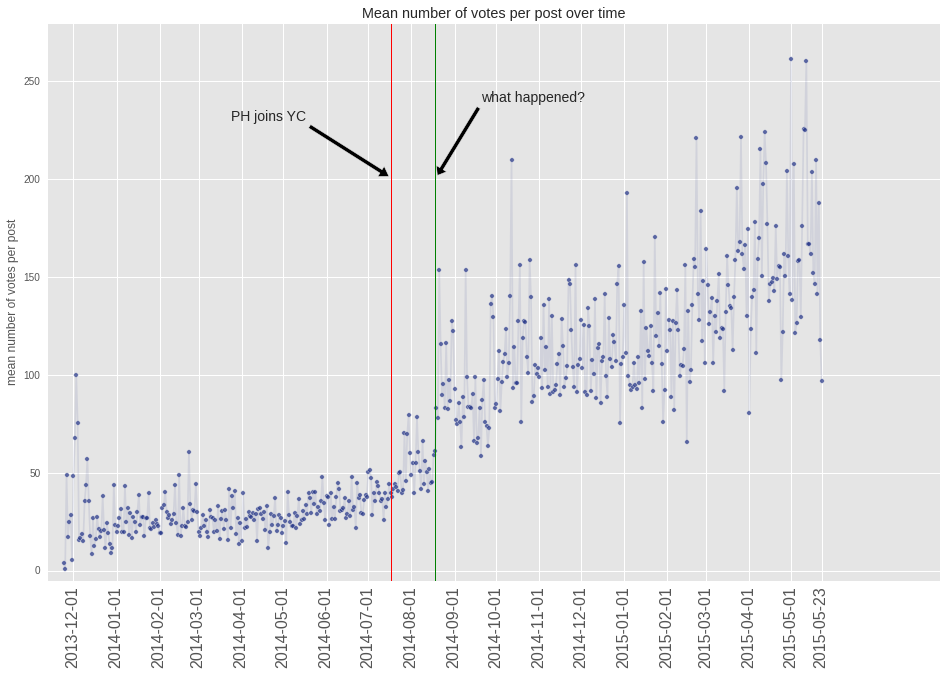

In [122]:
groupedVotesMeans = posts[['post_votes', 'post_data_date']].groupby('post_data_date').mean().reset_index()

plt.figure(figsize=(16,10))

X = [[i] for i in range(len(groupedVotesMeans))] 
Y = [[x] for x in groupedVotesMeans['post_votes']]

plt.scatter(X,Y, c='#223387', alpha=0.7)
plt.plot(X,Y, c='#223387', alpha=0.1)





xlabels = {}
for i in range(0, len(groupedVotesMeans.values)):
    date = str(groupedVotesMeans['post_data_date'].values[i])
    if (date.split('-')[2]=='01') | (i==len(groupedVotesMeans.values)-1):
        xlabels[i] = date
plt.xticks(xlabels.keys(), xlabels.values(), rotation=90, fontsize=16)


plt.axvline(235,c='r',linewidth=1)
plt.annotate('PH joins YC', xy=(237, 200), xytext=(120, 230), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05))


plt.axvline(267,c='g',linewidth=1)
plt.annotate('what happened?', xy=(267, 200), xytext=(300, 240), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05))


plt.ylim(-5,280)
plt.xlim(-12,630)
plt.title('Mean number of votes per post over time')
plt.ylabel('mean number of votes per post')
plt.xlabel('')
plt.show()

###Answer###  
In the last years the number of posts per day did not changed a lot.  
Analyzing the number of mean number of votes per post we can notice the "y-combinator effect" ("Product Hunt, The Popular Tech Product Discovery Site, Is In Current Y Combinator Batch" was published on TC in Jul 17, 2014)

# 
# 
# 
# 

#Is there any relation between number of votes and tagline?

###Let's create a words count

In [123]:
#let's create a unique document
taglines = str.join(' ', posts['post_tagline'].values)

In [124]:
taglines[:100]

'Keyboard interface to Google Chrome Timelapse for everyone Discover and geek out about cool new prod'

In [125]:
tokenizer = RegexpTokenizer(r'\w+')

words = tokenizer.tokenize(taglines)
words[:10]

['Keyboard',
 'interface',
 'to',
 'Google',
 'Chrome',
 'Timelapse',
 'for',
 'everyone',
 'Discover',
 'and']

In [126]:
words = [word.lower() for word in words]
words[:10]

['keyboard',
 'interface',
 'to',
 'google',
 'chrome',
 'timelapse',
 'for',
 'everyone',
 'discover',
 'and']

In [127]:
print len(words)
words = list(set(words))
print len(words)

102918
9583


In [128]:
words = [word for word in words if word not in stopwords.words("english")]

In [129]:
len(words)

9470

###words most used in taglines

In [130]:
words2postCount = {}
for tagline in posts['post_tagline'].values:
    tokens = tokenizer.tokenize(tagline)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    tokens = list(set(tokens)) #remove dupicates
    for word in tokens:
        if word in words2postCount.keys():
            words2postCount[word] = words2postCount[word] + 1
        else:
            words2postCount[word] = 0

In [131]:
len(words2postCount)

9470

In [132]:
words2postCount_sorted = sorted(words2postCount.items(), key=operator.itemgetter(1), reverse=True)

In [133]:
print 'word - #taglines'
for word2count in words2postCount_sorted[:30]:
    print word2count[0]+' - '+str(word2count[1])

word - #taglines
app - 802
new - 491
way - 462
create - 404
free - 393
simple - 384
ios - 374
share - 356
mobile - 353
web - 339
find - 332
time - 325
world - 324
get - 320
one - 315
best - 303
pre - 286
online - 279
friends - 272
email - 265
launch - 265
people - 261
game - 257
beautiful - 254
real - 254
make - 251
video - 245
iphone - 235
social - 234
apps - 234


In [134]:
# for every post let's get the tokenized tagline
posts2tokens = {}
for id2tagline in posts[['post_id','post_tagline']].values:
    id = id2tagline[0]
    tagline = id2tagline[1]
    tokens = [token.lower() for token in tokenizer.tokenize(tagline) if token not in stopwords.words("english")]
    tokens = list(set(tokens)) #remove duplicates
    posts2tokens[id] = tokens

In [135]:
posts2tokens[1345]

['1', 'brand', 'helping', 'reputation', 'build', 'others']

In [136]:
def getPostsWithAndWithoutWordInTagline(word):
    word = word.lower()
    ids_with = []
    ids_without = []    
    for id in posts['post_id'].values:
        if word in posts2tokens[id]:
            ids_with.append(id)
        else:
            ids_without.append(id)                
    w = posts[posts.post_id.isin(ids_with)]
    wout = posts[posts.post_id.isin(ids_without)]       
    return w,wout

In [137]:
getPostsWithAndWithoutWordInTagline('startup')[0].head()

,post_id,post_data,post_name,post_tagline,post_comments,post_votes,post_url,user_id,user_name,user_nickname,post_data_date,post_data_year,post_data_week,post_data_week_unique,post_data_weekday,post_data_hour,occ
14313,277,2013-12-16T14:18:25.900-08:00,Startup Framework,Suit up your startup.,2,13,http://www.producthunt.com/r/4605016749/277?ap...,13,Derek Shanahan,dshan,2013-12-16,2013,51,201351,0,22,1
14217,393,2013-12-21T13:37:59.814-08:00,Lyve,Formerly stealth startup Black Pearl Systems r...,1,4,http://www.producthunt.com/r/c1181dd239/393?ap...,26,Adam Kazwell,kaz,2013-12-21,2013,51,201351,5,21,1
14202,403,2013-12-22T09:28:55.413-08:00,Clerky,Startup Legal Setup Assistance,2,24,http://www.producthunt.com/r/6d4e6c6e48/403?ap...,85,Kam Bain,kam_bain,2013-12-22,2013,51,201351,6,17,1
13909,738,2014-01-12T10:56:29.388-08:00,Startup Letters,Startup Quote as an email newsletter,5,23,http://www.producthunt.com/r/03f107107b/738?ap...,934,Dave Ambrose,daveambrose,2014-01-12,2014,2,201402,6,18,1
13835,820,2014-01-16T09:23:07.652-08:00,Founder Suite,Tools to get startup sh*t done!,3,33,http://www.producthunt.com/r/075c741f7c/820?ap...,79,Kevin William David,kwdinc,2014-01-16,2014,3,201403,3,17,1


In [138]:
#words used in 20+ taglines
usedWords = [word for word in words2postCount.keys() if words2postCount[word]>=20]

In [139]:
len(usedWords)

687

In [140]:
# what is the difference between mean votes of posts 
# that containt a specific word in the tagline and
# mean votes of posts that don't containt that specific 
# word in the tagline
def getWordStrength(word):              
    w,wout = getPostsWithAndWithoutWordInTagline(word)
    w_mean =  round(np.mean(w['post_votes']), 1)
    w_std = round(np.std(w['post_votes']), 1)
    wout_mean = round(np.mean(wout['post_votes']), 1)
    diff = round(w_mean-wout_mean, 1)
    std2meanRatio = round(w_std/w_mean, 2)
    return [word, diff, len(w), std2meanRatio]

In [141]:
getWordStrength('startup')

['startup', 118.1, 125, 1.05]

In [142]:
word2strength = []
i=0
for word in usedWords:
    print i,
    i+=1
    word2strength.append(getWordStrength(word))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [143]:
word2strength[:5]

[['second', 33.5, 30, 1.68],
 ['kids', -35.0, 81, 1.09],
 ['browse', -1.9, 30, 1.53],
 ['music', -20.4, 231, 1.16],
 ['99', -8.9, 23, 1.1]]

In [144]:
word2strength = sorted(word2strength, key=operator.itemgetter(1), reverse=True)

In [145]:
print("{: >13} {: >6} {: >4} {: >5}".format(*['word', 'AvgDif', 'occ', 'CV']))
print("{: >13} {: >6} {: >4} {: >5}".format(*['----', '----', '----', '----']))
for v in word2strength[:100]:
    #print v
    #''.format(v)
    print("{: >13} {: >6} {: >4} {: >5}".format(*v))
    #print "%s\t%d\t%d\t%d" %(v[0],v[1],v[2],v[4])

         word AvgDif  occ    CV
         ----   ---- ----  ----
    resources  207.1   26  1.71
    generator  163.8   22  1.28
        slack  141.2   53  0.87
     startups  136.2   94  1.56
       movies  120.0   35  1.29
     material  119.9   21  0.94
      startup  118.1  125  1.05
           ux  111.0   23  0.68
        stock  109.1   34  1.45
         paid  108.2   21  1.75
     founders  106.9   27  0.95
       sketch  104.9   31  0.81
         menu   99.3   21  1.08
   everywhere   98.4   24  1.48
    interface   98.2   32   1.2
   collection   94.7   48  1.32
  prototyping   90.3   27  0.91
         busy   89.3   22  1.54
       domain   88.6   30  1.56
         hunt   88.3  105  0.88
     schedule   87.8   26  1.72
          mac   87.6  216  1.18
        icons   87.5   49  0.94
  programming   84.9   29  1.21
entrepreneurs   84.1   37  1.25
       course   83.1   33  0.71
      product   81.6  165  1.06
      someone   79.7   26  2.41
    templates   78.8   26  1.15
        

In [146]:
word2strength = sorted(word2strength, key=operator.itemgetter(1), reverse=False)
print("{: >15} {: >6} {: >4} {: >5}".format(*['word', 'AvgDif', 'occ', 'CV']))
print("{: >15} {: >6} {: >4} {: >5}".format(*['----', '----', '----', '----']))
for v in word2strength[:100]:
    #print v
    #''.format(v)
    print("{: >15} {: >6} {: >4} {: >5}".format(*v))
    #print "%s\t%d\t%d\t%d" %(v[0],v[1],v[2],v[4])

           word AvgDif  occ    CV
           ----   ---- ----  ----
           bird  -57.7   23   1.7
     enterprise  -57.0   24  0.88
         reader  -56.7   26  0.95
         flappy  -56.7   21  1.71
      decisions  -54.0   23  1.05
          bring  -53.7   24  0.92
          gifts  -53.2   23  1.32
  communication  -51.0   22  0.99
           case  -49.1   25  0.82
         sports  -47.4   45  1.14
       security  -46.2   31  0.94
           rate  -45.4   23  0.97
       portable  -44.5   33  0.94
           baby  -43.9   25  1.44
         market  -43.4   24   1.1
           peer  -42.7   22  1.16
      addictive  -42.6   24  0.78
recommendations  -42.5   28  0.99
       friendly  -41.9   22  0.77
      bluetooth  -41.9   25  1.02
        anytime  -41.7   28  0.94
        moments  -41.5   25  1.41
           bike  -40.6   34  1.56
        virtual  -40.2   43   1.1
       shopping  -40.1   29  1.01
           lets  -40.0   31  0.76
         wallet  -39.8   26  0.86
          even

###let's create some function to make easy inspect the results

In [147]:
def plotWithWordInTagline(word):
    f, (ax1, ax2) = plt.subplots(ncols=2)
    f.set_size_inches(16, 8)
    w, wout = getPostsWithAndWithoutWordInTagline(word)
       
    wout_mean = np.mean(wout['post_votes'].values)
    wout_posts = ax1.scatter(wout['post_id'].values,
                wout['post_votes'].values,
                c='#223387',
                alpha=0.1,
                linewidths=0,
                label='posts without '+word+' in the tagline')
    
 
    w_mean = np.mean(w['post_votes'].values)      
    w_posts = ax1.scatter(w['post_id'].values,
                w['post_votes'].values,
                c='r',
                alpha=1,
                linewidths=0,
                label='posts with '+word+' in the tagline')
    
    
    woutMeanLine = ax1.axhline(wout_mean,c='black', label='mean #votes for posts without '+word+' in the tagline')
    wMeanLine = ax1.axhline(w_mean,c='r', label='mean #votes for posts with '+word+' in the tagline')
    
    ax1.set_ylim(-50,1500)
    ax1.set_xlim(-500,23000)
      
    w['post_votes'].hist(bins=20,ax=ax2)
     
    ax1.legend(handles=[w_posts, wout_posts, wMeanLine, woutMeanLine], fontsize=14)
    ax1.set_title('Word \''+word+'\' - post w vs. post w/out')
    ax1.set_ylabel('number of votes')
    ax1.set_xlabel('post id')
    
    ax2.set_title('Word \''+word+'\' - distribution ')
    ax2.set_xlabel('number of votes')
    ax2.set_ylabel('number of post with x votes')
    plt.show()

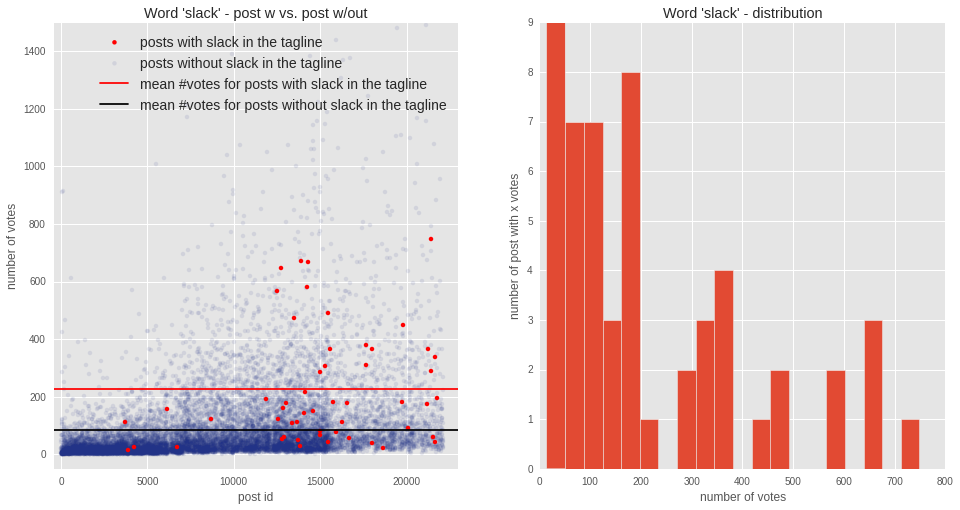

In [148]:
plotWithWordInTagline('slack')

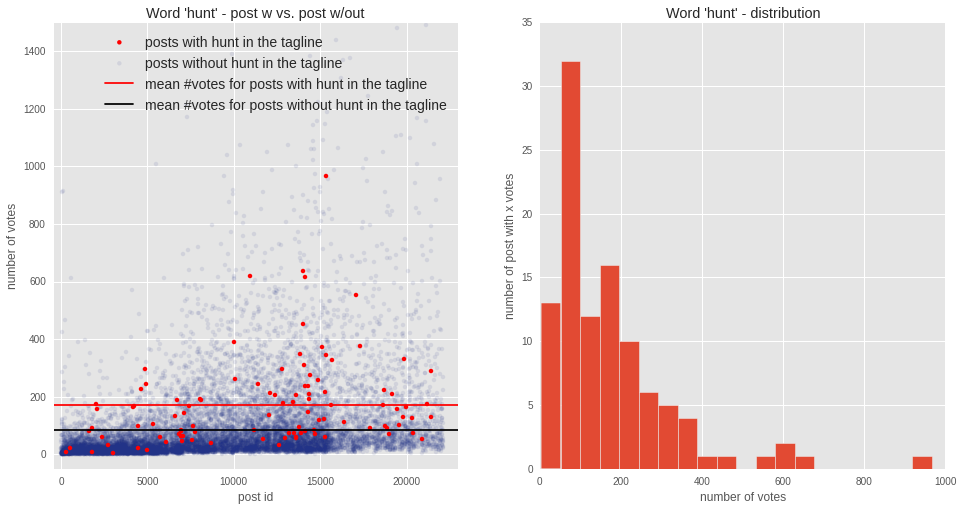

In [149]:
plotWithWordInTagline('hunt')

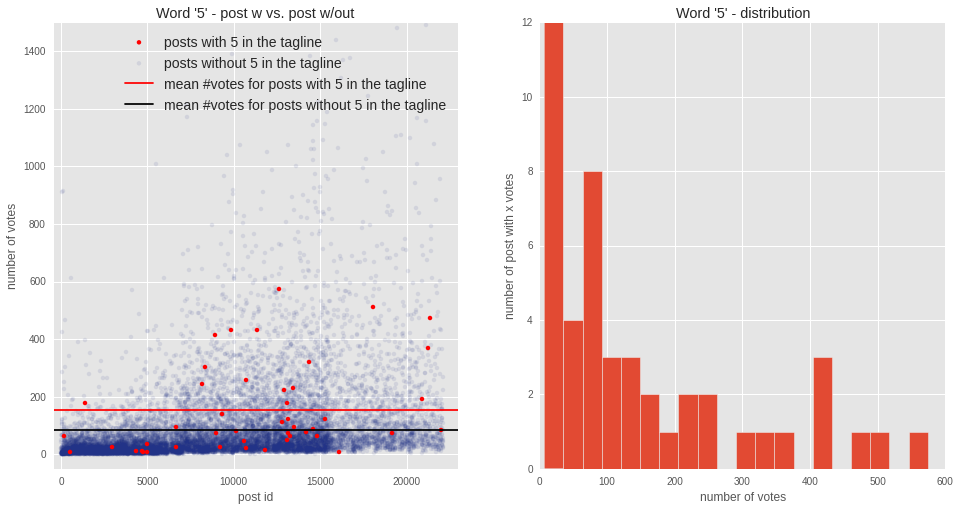

In [150]:
plotWithWordInTagline('5')

In [151]:
for v in getPostsWithAndWithoutWordInTagline('5')[0].sort('post_votes', ascending=False)[['post_name', 'post_tagline', 'post_votes']].values[:10]:
    print v[0]+'\t'+v[1]+'\t ('+str(v[2])+' votes)'
    print

Highbrow	Expand Your Knowledge Universe in just 5 minutes a day	 (574 votes)

Picnic	Register a new website with one click. Live in 5 mins.	 (513 votes)

8^8	Find your soulmate. Take 5 mins to answer these questions.	 (472 votes)

Gigster	Hire a contract developer in 5 minutes	 (432 votes)

Ethanifier	Build your own Ethan" app in under 5 minutes"	 (431 votes)

Xcode for Designers	Learn how to create native iOS apps in 5 days	 (413 votes)

DeepLink Kit	Add deep links to your app in 5 minutes.	 (368 votes)

RefreshBox	Create and get subscribers to your weekly 5-link-newsletter	 (320 votes)

Sidebar	5 curated design links, every day	 (303 votes)

Pocket Casts	Powerful podcast manager for iOS & Android. New v.5 release.	 (257 votes)

